# ACD Models

**This notebook is written in python 3 **

Louis Echard - 42355

We want to use ACD like models to predict the information (tick) arrival time. 

The standard ACD Model looks like this :
$\psi(i) = \alpha_0 + \sum_{0<j=<p} \alpha_j x_{i-j} + \sum_{0=<j=<q} \beta_j \psi_{i-j}$

On which constraints exist.


We want to include shocks on the underlying and trade size in our model

Let's keep it for calls :
With K:Strike, F:Underlying

Moneyness : $ \omega  =  K/F$   

Shocks on the underlying : $ \lambda(F) = Time Weighted TradingVolumePastXTrades  $

Shocks on the Option : $ \lambda(O) =  Time Weighted TradingVolumePastXTrades $

dt : weighted time since volumes by volume

$\psi(i) = \alpha_0 + \sum_{1=<j=<p} \alpha_j log(x_{i-j}) + \sum_{0=<j=<q} \beta_j \psi_{i-j} + \sum_{0=<j=<s} \gamma_j \omega_{i-j} \lambda (O)_{i-j}   + \sum_{0=<j=<r} \delta_j \omega_{i-j} \lambda (U)_{i-j}$

As proposed by Bauwens and Giot (2000) we can take the logs to avoid constraints on the variables (keep stationarity)

In [3]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip
from pathlib import Path

from pandas.plotting import parallel_coordinates
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
plt.style.use('seaborn')

In [4]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [5]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

In [19]:
#load the data
#data = json.load(open('feeddata_10.json'))

#cleaner : keeps the file compressed on the computer
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))

In [74]:
#(datetime.utcfromtimestamp(data[0]["created"]/1000000))

# I. Typical ACD Model on Futures:
I didn't delete it, but this was a test, you can skip this part

In [4]:
#test of EACD on futures

def residualTotalEACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    
    p = pqs_[0]
    q = pqs_[1]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]    
    
    initialized = False
    first = True
    for idx, tick in enumerate(data):
    
        myBook = tick["book"]
           
        if myBook[5] == '1' and  tick['type']=='tick':   #let's forget about mini futures
            myContract = getBookContract(myBook[8:11],myBook[3])
    
            if myContract is CONTRACTTYPE.FUTURE:
                if initialized and not first :

                    #calculate alphas and betas parts
                    alphaSum = 0.0
                    betaSum = 0.0            
                    for idx2,alpha in enumerate(alphas): 
                        #print(xs)
                        alphaSum = alphaSum + alpha*xs[idx2] #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                    for idx2,beta in enumerate(betas):
                        #print(psis)
                        if len(psis)>idx2:
                            betaSum = betaSum + beta*psis[idx2]

                    expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                    psis.append(expectedTime)
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)


                    errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                    check1.append(expectedTime)
                    check2.append(xs[p])

                elif first:
                    first = False
                else:
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)
                    if len(xs) == p:
                        initialized = True

                myPastTime = datetime.utcfromtimestamp(tick["created"]/1000000)

                #maintain right array size
                if len(xs)>p:
                    xs.pop(0)
                if len(psis)>q:
                    psis.pop(0)  

                if idx > 2000 :
                    break
    #return errs,check1,check2
    return np.average(errs)

In [5]:
#parameters:
alpha0 = 0.0
alphas = [1,1,1,1,1,1]
betas = [1,1,1,1]

params0 = [alpha0] + alphas + betas

### Test on Futures : LSE with constraints

In [6]:
def constraint1(x):
    return -np.sum(x)+len(x)

cons = (
            {'type': 'ineq',
             'fun' : constraint1
            }
          ,
              {'type': 'ineq',
               'fun' : lambda x: x
              }
        )

In [78]:

optimize.minimize(residualTotalEACD,params0,args=([len(alphas), len(betas)]), method='COBYLA', constraints=cons, options={'maxiter':10000})

     fun: 1987.1733927191476
   maxcv: 1.0135269667632516e-19
 message: 'Optimization terminated successfully.'
    nfev: 8687
  status: 1
 success: True
       x: array([  1.34372277e+00,  -9.46518187e-20,  -7.80014531e-21,
        -9.89682264e-20,  -9.51935771e-20,  -1.00768977e-19,
         2.65618311e-01,   3.67002166e-01,   7.79119699e-22,
         2.93608638e-01,  -1.01352697e-19])

In [79]:
# we just check what we would get with random variables
paramsTest = [1,1,1]

for idx,param in enumerate(paramsTest):
    paramsTest[idx] = paramsTest[idx]*(np.random.rand()*5)
print(residualTotalEACD(paramsTest, [len(alphas), len(betas)]))
print(paramsTest)

177630.040866
[3.8996560249952346, 4.994533817615261, 4.6851179353219985]


# II. New Model :

# Let's calculate the models for an option book, then we can compare the results to some benchmark

In [8]:
#dataExtraction to save calculation during optimization
#only taking the strike of interest and the future
#precalculating tick times

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = []
    myCounter = 0
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
                myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                
            elif tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
            elif tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'tick',
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * round((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [9]:
#Simple EACD for Options
def residualTotalEACD(params_, pqs_):
    check1 = [] #sanity check
    check2 = [] #sanity check
    
    #variables of Interest:
    errs = [] #our squared errors
    psis = [] #our estimated waiting time
    xs = [] #the real waiting time
    
    
    p = pqs_[0] #number of lags for real waiting time used in calculation
    q = pqs_[1] #number of lags for estimated waiting time used in calculation
    
    alpha0 = params_[0] #constant
    alphas = params_[1:p+1] #parameters for real waiting time
    betas = params_[p+1:q+p+1] #parameters for estimated waiting time
    
    initialized = False # when we have enough lagged examples 
    first = True #the first data point has to be treated differently
    counter = 0 #the counter is just a check
    
    for idx, tick in enumerate(myDataForRun):
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0) #we keep the right size
            if len(psis)>q:
                psis.pop(0)  #we keep the right size
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that

                expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime) #sanity check
                check2.append(xs[p]) #sanity check

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0) #we keep the right size
        if len(psis)>q:
            psis.pop(0)  #we keep the right size


#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [10]:
#ACD model with added impact on current option book and underlying book
def residualTotalModACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    volumeO = []
    volumeF = []
    TO = []
    TF = []
    
    
    p = pqs_[0]
    q = pqs_[1]
    r = pqs_[2]
    s = pqs_[3]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]
    gammas =  params_[q+p+1:q+p+1+r]
    deltas = params_[q+p+r+1:q+p+r+s+1]
    
    initialized = False
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.FUTURE: 
            volumeF.append(tick['volume'])
            TF.append(tick['received'])
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.CALL: 
            volumeO.append(tick['volume'])
            TO.append(tick['received'])
            
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0)
            if len(psis)>q:
                psis.pop(0)  
            if len(volumeO)>r:
                volumeO.pop(0)
                TO.pop(0)
            if len(volumeF)>s:
                volumeF.pop(0)  
                TF.pop(0)
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that
                for idx2,gamma in enumerate(gammas):
                        gammaSum = gammaSum + gamma*volumeO[idx2]*(tick['received']-TO[idx2]).microseconds/1000
                for idx2,delta in enumerate(deltas):
                        deltaSum = deltaSum + delta*volumeF[idx2]*(tick['received']-TF[idx2]).microseconds/1000

                expectedTime = alpha0 + alphaSum +  betaSum + gammaSum + deltaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime)
                check2.append(xs[p])

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p and len(volumeO) == r and len(volumeF) == s:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0)
        if len(psis)>q:
            psis.pop(0)  
        if len(volumeO)>r:
            volumeO.pop(0)
            TO.pop(0)
        if len(volumeF)>s:
            volumeF.pop(0)  
            TF.pop(0)

#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [11]:
#@deprecated

# #parameters:
# alpha0 = 0.0
# alphas = [.01,.01,.01,.01,.01,.01]
# betas = [.01,.01,.01,.01]
# gammas = [.01,.01]
# deltas = [.01,.01]
# params0 = [alpha0] + alphas + betas + gammas + deltas
# #errs,check1,check2 = residualTotalEACD(params, len(alphas), len(betas))

# p = len(alphas)
# q = len(betas)
# r = len(gammas)
# s = len(deltas)

# alpha0 = params_[0]
# alphas = params_[1:p+1]
# betas = params_[p+1:q+p+1]
# gammas =  params_[q+p+1:q+p+1+r]
# deltas = params_[q+p+r+1:q+p+r+s+1]


In [12]:
nbOfDataPoints=10000

In [13]:
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data2017110110 = json.loads(f.read().decode("ascii"))

In [14]:
#extract interesting data, of x dataPoints for the specified strike

myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110110)

In [12]:
#function giving initial parameters and parameters size for both ACD models
def initParams(isSimpleACD, isSize):
    alpha0 = 0.0
    alphas = [.001,.001,.001,.001,.001,.001]
    betas = [.001,.001,.001,.001]
    gammas = [.001,.001]
    deltas = [.001,.001]
    if not isSize:
        if isSimpleACD:
            return [alpha0] + alphas + betas
        else:
            return [alpha0] + alphas + betas + gammas + deltas
    elif isSize:
        if isSimpleACD:
            return [len(alphas), len(betas)]
        else:
            return [len(alphas), len(betas), len(gammas), len(deltas)]


In [253]:
#test of running time 1
start_time = timeit.default_timer()
print(residualTotalModACD(initParams(False, False),initParams(False, True)))
print('takes ' + str(timeit.default_timer() - start_time) + ' seconds to run')

6718.16877033
takes 0.02806170029361965 seconds to run


In [256]:
#test of running time 2
paramsTest = initParams(False, False)
for i in range(0,10):
    for idx,param in enumerate(paramsTest):
        paramsTest[idx] = param*np.random.rand()*1.2
        start_time = timeit.default_timer()
    print(residualTotalModACD(paramsTest,initParams(False, True)))
    print("execution time in ms:",(timeit.default_timer() - start_time)*1000)


6817.13715912
execution time in ms: 27.716222743038088
6870.83259507
execution time in ms: 28.839939055615105
6877.38350975
execution time in ms: 28.01366989297094
6876.31017089
execution time in ms: 28.00830608975957
6882.9621161
execution time in ms: 27.8671406013018
6884.18156835
execution time in ms: 27.916633855056716
6879.97258666
execution time in ms: 27.84080921264831
6898.78442167
execution time in ms: 27.98928897755104
6904.70797411
execution time in ms: 28.25528474568273
6907.6133578
execution time in ms: 28.25650379236322


In [13]:
#benchmark n1 : 
#assume the next arrival time is equal to the last one
#e.g. we had to wait 10ms to get a new tick, we expect the next tick will come in 10ms
def residualSamePace() : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun): 
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            counter = counter + 1
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = ArrivalTime
            else:
                if counter  > 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
            
    return np.mean(errs)

#benchmark n2 : 
#assume the next arrival time is an exponential moving average of the last ones
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            counter = counter + 1
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  > 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
    return np.mean(errs)

### evaluate benchmarks

In [224]:

#benchmark 1 : next tick arrives at same pace as the last
res_bench1_10 = residualSamePace()
print("The squared errors for the flat arrival time is :",res_bench1_10, "\n")
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2_10 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print("The squared errors for the flat arrival time is :", res_bench2_10.fun, " with best solution x: ", res_bench2_10.x)


The squared errors for the flat arrival time is : 9165.69596874 



C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply


The squared errors for the flat arrival time is : 5799.129861051124  with best solution x:  [ 0.90730825]


In [225]:
#benchmark 3 : next tick arrives with EACD model
res_bench3_10 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
print(res_bench3_10)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


     fun: 5324.841356137033
     jac: array([-0.00201416,  0.00189209,  0.00268555, -0.00268555,  0.00305176,
        0.00073242, -0.00128174,  0.06115723, -0.04602051,  0.02313232,
        0.03289795])
 message: 'Optimization terminated successfully.'
    nfev: 914
     nit: 66
    njev: 66
  status: 0
 success: True
       x: array([ 0.07797459, -0.43128864,  1.74987552, -6.01700823, -2.52349263,
       -1.19280172,  8.63008568, -0.54785057,  0.79311569,  0.3707796 ,
        0.37626312])


In [226]:
res_ModACD_10 = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
print(res_ModACD_10)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 5342.030770750242
     jac: array([  3.05175781e-04,  -2.31933594e-03,   4.82177734e-03,
        -2.50244141e-03,   4.15039062e-03,  -4.88281250e-04,
         2.99072266e-03,   5.52368164e-02,  -7.44628906e-03,
         5.82275391e-02,   6.10351562e-05,   5.80505371e-01,
         6.92626953e-01,   3.68688965e+00,  -3.34472656e-01])
 message: 'Optimization terminated successfully.'
    nfev: 1100
     nit: 61
    njev: 61
  status: 0
 success: True
       x: array([  2.44706826e+01,   2.92287726e-01,   3.42689325e+00,
         2.26281373e+00,   3.54420058e+00,   1.14820347e+01,
         8.96698453e+00,  -1.22344439e-01,   2.03879461e-01,
         3.56547302e-02,  -1.07080917e+00,   4.76548904e-03,
         1.40005239e-02,   1.39221772e-04,   9.02945036e-04])


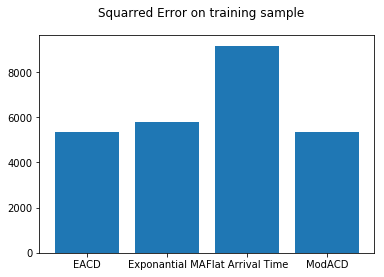

In [227]:
dataToPlot = {'Flat Arrival Time': res_bench1_10, 'Exponantial MA': res_bench2_10.fun, 'EACD': res_bench3_10.fun, 'ModACD': res_ModACD_10.fun}
names = list(dataToPlot.keys())
values = list(dataToPlot.values())

fig, axs = plt.subplots()
axs.bar(names, values)
fig.suptitle('Squarred Error on training sample')

plt.show()

The squared errors for the flat arrival time is : 3476.43734849 

The squared errors for the flat arrival time is : 

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


2298.915947169761  with best solution x:  [ 0.60064909]
     fun: 1851.261397226359
     jac: array([ 0.00073242, -0.00563049,  0.00469971, -0.0057373 ,  0.00413513,
       -0.00372314,  0.0035553 ,  0.03240967,  0.00485229, -0.00944519,
       -0.00817871])
 message: 'Optimization terminated successfully.'
    nfev: 735
     nit: 53
    njev: 53
  status: 0
 success: True
       x: array([ 6.32253267,  0.2410081 , -2.0991684 ,  0.1753158 ,  1.73915648,
        2.07208888,  3.14091887,  0.85159355,  0.11067023, -0.13064207,
       -0.36373694])


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 1822.0051264135705
     jac: array([ -5.49316406e-04,  -7.17163086e-04,  -2.59399414e-04,
         2.28881836e-04,  -9.30786133e-04,  -9.15527344e-05,
        -6.25610352e-04,  -5.26428223e-03,  -3.63159180e-03,
        -1.03149414e-02,  -1.40533447e-02,  -8.18283081e-01,
         2.92053223e-02,  -6.77185059e-02,  -3.42971802e-01])
 message: 'Optimization terminated successfully.'
    nfev: 835
     nit: 46
    njev: 46
  status: 0
 success: True
       x: array([  2.46285476e+01,   5.21709219e-01,   4.04734355e-01,
         1.87420941e+00,   3.41376920e+00,   2.92913613e+00,
         3.18007819e+00,   9.78344281e-02,  -1.93664727e-01,
        -5.42541709e-01,  -6.63397297e-01,   2.01239343e-03,
         4.89425024e-03,   3.88181876e-03,   3.70921505e-03])


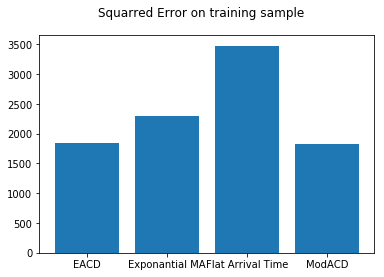

In [228]:
#testing on different window
with gzip.open('data\\2017.11.01\\feeddata_09.json.gz', "rb") as f:
    data2017110109 = json.loads(f.read().decode("ascii"))
    
myDataForRun = extractInterestingData(nbOfDataPoints,'335',data11)

#benchmark 1 : next tick arrives at same pace as the last
res_bench1 = residualSamePace()
print("The squared errors for the flat arrival time is :",res_bench1, "\n")
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print("The squared errors for the flat arrival time is :", res_bench2.fun, " with best solution x: ", res_bench2.x)

#benchmark 3 : next tick arrives with EACD model
res_bench3 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
print(res_bench3)
res_ModACD = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
print(res_ModACD)

dataToPlot = {'Flat Arrival Time': res_bench1, 'Exponantial MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
names = list(dataToPlot.keys())
values = list(dataToPlot.values())

fig, axs = plt.subplots()
axs.bar(names, values)
fig.suptitle('Squarred Error on training sample')

plt.show()

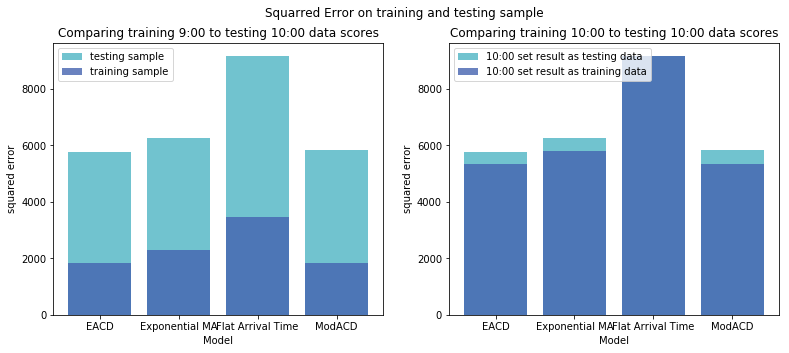

In [229]:
#let's test the data trained on 10am on the 09am set
myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110110)

residualSamePace()

dataToPlot1 = {'Flat Arrival Time': residualSamePace(), 'Exponential MA': residualExpoMovingAverage(res_bench2.x), 'EACD': residualTotalEACD(res_bench3.x,initParams(True,True)), 'ModACD': residualTotalModACD(res_ModACD.x,initParams(False,True))}
names1 = list(dataToPlot1.keys())
values1 = list(dataToPlot1.values())

dataToPlot2 = {'Flat Arrival Time': res_bench1, 'Exponential MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
names2 = list(dataToPlot2.keys())
values2 = list(dataToPlot2.values())

dataToPlot3 = {'Flat Arrival Time': res_bench1_10, 'Exponential MA': res_bench2_10.fun, 'EACD': res_bench3_10.fun, 'ModACD': res_ModACD_10.fun}
names3 = list(dataToPlot3.keys())
values3 = list(dataToPlot3.values())

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].bar(names1, values1, color = "#139caf", alpha = 0.6, label = "testing sample")
axs[0].bar(names2,values2, color = '#4563b0', alpha = 0.8, label = "training sample")
axs[0].set_ylabel("squared error")
axs[0].set_xlabel("Model")
axs[0].set_title("Comparing training 9:00 to testing 10:00 data scores")
axs[0].legend(loc = 'upper left')

axs[1].bar(names1,values1, color = "#139caf" , alpha = 0.6, label = "10:00 set result as testing data")
axs[1].bar(names3, values3, color ='#4563b0' , alpha = 0.8, label = "10:00 set result as training data")
axs[1].set_ylabel("squared error")
axs[1].set_xlabel("Model")
axs[1].set_title("Comparing training 10:00 to testing 10:00 data scores")
axs[1].legend(loc = 'upper left')

fig.suptitle('Squarred Error on training and testing sample')

plt.show()

#### We can see that the testing sample has naturally more variance than the training sample (Flat Arrival Time is not being trained). We can however see that the EACD and Mod ACD fail to be very performant in comparison with a simpler model (exponential MA).

In [49]:
result = pd.DataFrame()
paramLearn = pd.DataFrame()

In [54]:
#testing on different window
# # result = pd.DataFrame()
# paramLearn = pd.DataFrame()
for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_13.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_13.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)

        #benchmark 1 : next tick arrives at same pace as the last
        res_bench1 = residualSamePace()
    #     print("The squared errors for the flat arrival time is :",res_bench1, "\n")
        #benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
        res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
    #     print("The squared errors for the flat arrival time is :", res_bench2.fun, " with best solution x: ", res_bench2.x)

        #benchmark 3 : next tick arrives with EACD model
        res_bench3 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
    #     print(res_bench3)
        res_ModACD = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
    #     print(res_ModACD)

    #     dataToPlot = {'Flat Arrival Time': res_bench1, 'Exponential MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
    #     names = list(dataToPlot.keys())
    #     values = list(dataToPlot.values())

    #     fig, axs = plt.subplots()
    #     axs.bar(names, values)
    #     fig.suptitle('Squarred Error on training sample')

    #     plt.show()
        s0 = pd.Series([res_bench1], name='Flat Arrival')
        s1 = pd.Series([res_bench2.fun], name='Exponential')
        s2 = pd.Series([res_bench3.fun], name='EACD')
        s3 = pd.Series([res_ModACD.fun], name='ModACD')

        dfTemp = pd.concat([s0, s1, s2, s3], axis=1)

        result = pd.concat([result, dfTemp], axis=0, ignore_index=True)

        p0 = pd.Series([1], name='Flat Arrival')
        p1 = pd.Series(res_bench2.x, name='Exponential')
        p2 = pd.Series([res_bench3.x], name='EACD')
        p3 = pd.Series([res_ModACD.x], name='ModACD')

        dfTemp2 = pd.concat([p0, p1, p2, p3], axis=1)

        paramLearn = pd.concat([paramLearn, dfTemp2], axis=0, ignore_index=True)
    

{'received': 1491192000057504, 'created': 1491192000056681, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 281.95, 'ask_volume_0': 261, 'ask_price_1': 282.0, 'ask_volume_1': 363, 'ask_price_2': 282.05, 'ask_volume_2': 293, 'ask_price_3': 282.1, 'ask_volume_3': 311, 'ask_price_4': 282.15, 'ask_volume_4': 243, 'bid_price_0': 281.9, 'bid_volume_0': 83, 'bid_price_1': 281.85, 'bid_volume_1': 366, 'bid_price_2': 281.8, 'bid_volume_2': 306, 'bid_price_3': 281.75, 'bid_volume_3': 345, 'bid_price_4': 281.7, 'bid_volume_4': 386}
280


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value 

{'received': 1491278400002317, 'created': 1491278400001356, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 282.05, 'ask_volume_0': 189, 'ask_price_1': 282.1, 'ask_volume_1': 346, 'ask_price_2': 282.15, 'ask_volume_2': 317, 'ask_price_3': 282.2, 'ask_volume_3': 285, 'ask_price_4': 282.25, 'ask_volume_4': 295, 'bid_price_0': 282.0, 'bid_volume_0': 108, 'bid_price_1': 281.95, 'bid_volume_1': 295, 'bid_price_2': 281.9, 'bid_volume_2': 326, 'bid_price_3': 281.85, 'bid_volume_3': 388, 'bid_price_4': 281.8, 'bid_volume_4': 312}
280
{'received': 1491364800201149, 'created': 1491364800200417, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 279.65, 'ask_volume_0': 13, 'ask_price_1': 279.7, 'ask_volume_1': 223, 'ask_price_2': 279.75, 'ask_volume_2': 235, 'ask_price_3': 279.8, 'ask_volume_3': 293, 'ask_price_4': 279.85, 'ask_volume_4': 275, 'bid_price_0': 279.6, 'bid_volume_0': 188, 'bid_price_1': 279.55, 'bid_volume_1': 275, 'bid_price_2': 279.5, 'bid_volume_2': 274, 'bid_price_3':

{'received': 1493179200072171, 'created': 1493179200072022, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 286.6, 'ask_volume_0': 59, 'ask_price_1': 286.65, 'ask_volume_1': 263, 'ask_price_2': 286.7, 'ask_volume_2': 311, 'ask_price_3': 286.75, 'ask_volume_3': 293, 'ask_price_4': 286.8, 'ask_volume_4': 238, 'bid_price_0': 286.55, 'bid_volume_0': 152, 'bid_price_1': 286.5, 'bid_volume_1': 276, 'bid_price_2': 286.45, 'bid_volume_2': 341, 'bid_price_3': 286.4, 'bid_volume_3': 349, 'bid_price_4': 286.35, 'bid_volume_4': 314}
285
{'received': 1493265600053262, 'created': 1493265600052477, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 286.75, 'ask_volume_0': 178, 'ask_price_1': 286.8, 'ask_volume_1': 228, 'ask_price_2': 286.85, 'ask_volume_2': 277, 'ask_price_3': 286.9, 'ask_volume_3': 271, 'ask_price_4': 286.95, 'ask_volume_4': 228, 'bid_price_0': 286.7, 'bid_volume_0': 156, 'bid_price_1': 286.65, 'bid_volume_1': 264, 'bid_price_2': 286.6, 'bid_volume_2': 251, 'bid_price_3':

In [56]:
writer = pd.ExcelWriter('res02004-2611-13pm.xlsx')
result.to_excel(writer)
writer.save()

Now we can cluster the parameters into different groups; observe the mean performance of each group, test the grouped parameters (mean or different way) on the whole period : observe results robustess

In [203]:
paramsAndRes = pd.read_excel('fullParamModACD.xlsx')

In [204]:
print('we can observe a huge sampling variance')
paramsAndRes.describe()


we can observe a huge sampling variance


,month,result,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,param_9,param_10,param_11,param_12,param_13,param_14,param_15
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,7.409091,15049.979517,5.935251,-1.599903,-6.041278,-2.130816,3.330519,5.452993,15.051794,0.418554,0.172424,-0.144455,-0.058777,0.000916,0.004438,0.000197,0.000622
std,3.253293,12552.152622,12.134442,2.781678,8.520878,8.975469,7.280839,12.199367,8.110299,0.422782,0.485321,0.424220,0.603983,0.003855,0.011337,0.001198,0.001285
min,4.000000,223.866774,-19.146951,-8.378077,-33.023937,-41.183058,-22.659335,-22.672941,0.938359,-0.566882,-1.090507,-1.518473,-1.474688,-0.017229,-0.000530,-0.001472,-0.000675
25%,4.000000,5045.197481,0.056445,-3.695933,-10.449266,-5.791691,1.977019,0.945164,8.433325,0.118494,-0.131647,-0.354827,-0.496619,-0.000053,0.000020,-0.000123,-0.000007
50%,10.000000,12093.966091,2.334920,-1.438995,-4.557772,-0.690267,3.427629,3.931964,13.930897,0.482836,0.251577,-0.132822,-0.127993,0.000043,0.000366,0.000010,0.000090
75%,10.000000,21525.801153,8.216934,0.066245,-1.228577,2.691884,7.363424,10.964088,21.353626,0.769892,0.505641,-0.038386,0.155014,0.000645,0.002139,0.000168,0.000610
max,11.000000,55857.832228,63.648431,7.053659,11.696785,20.399555,16.142830,63.630958,36.069223,0.994354,1.321436,1.080831,1.719365,0.019420,0.059736,0.008449,0.005238


### Once we have performed a benchmark on the training set, we need to compare the benchmarks on a testing set
# Then we perform statistical tests on the soundness/robustness of our measures. 

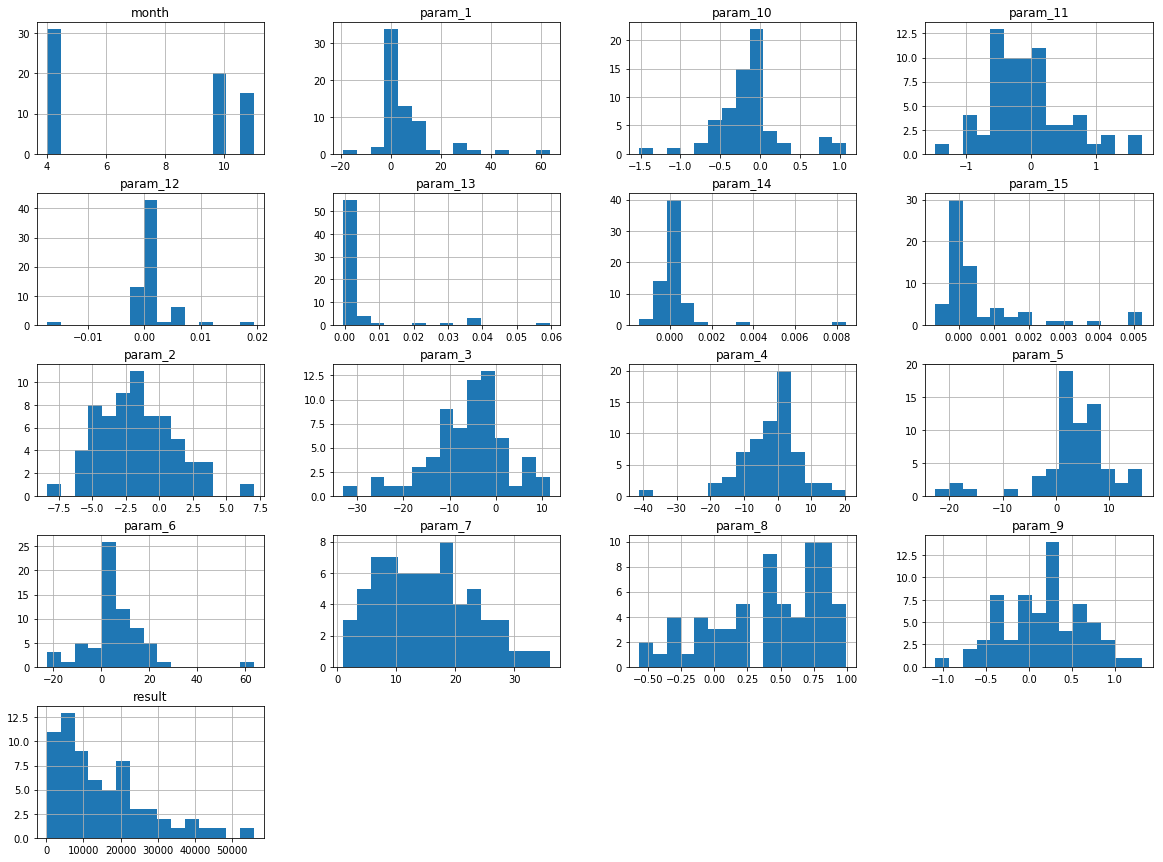

In [214]:

paramsAndRes.hist(bins=15,figsize=(20,15))
plt.show()

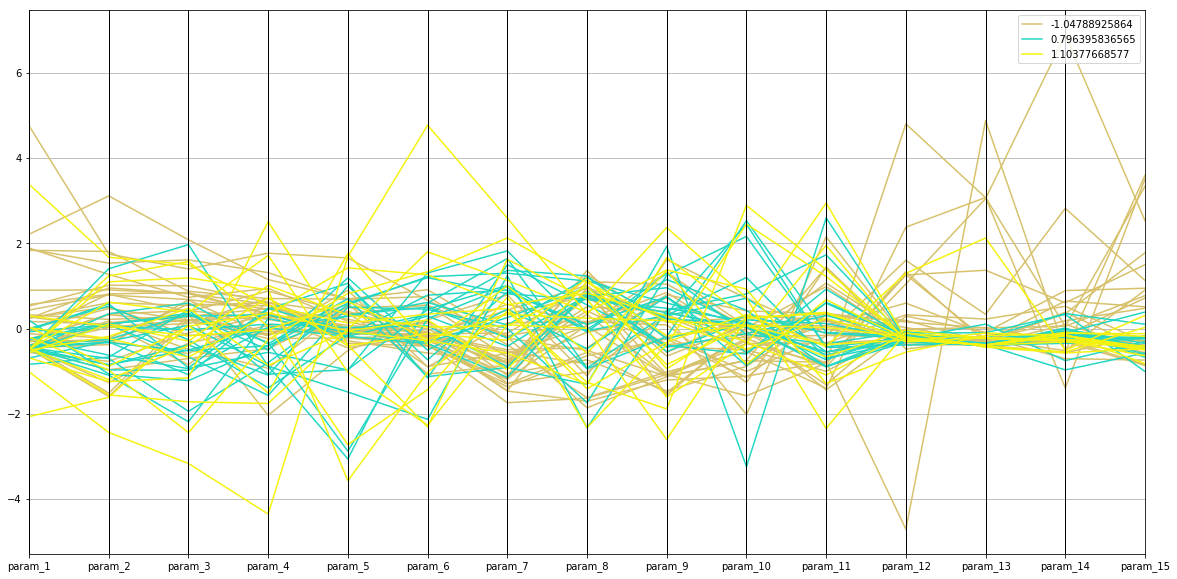

In [215]:

plt.figure(figsize=(20,10))

parallel_coordinates(((paramsAndRes-paramsAndRes.mean())/paramsAndRes.std()).drop('result',axis=1), "month")
plt.show()

In [216]:

for n in range(2, 20):
   
    
    clusterer = GMM(n_components=n, random_state=11)

    clusterer.fit(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

    preds = clusterer.predict(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

    centers = clusterer.means_

    
    score = silhouette_score(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1), preds, random_state=1)
    print('GMM silhouette score for {} clusters is {}'.format(n,score))

GMM silhouette score for 2 clusters is 0.4311841992473433
GMM silhouette score for 3 clusters is 0.36778726955431723
GMM silhouette score for 4 clusters is 0.1901057975487193
GMM silhouette score for 5 clusters is 0.2224656574286254
GMM silhouette score for 6 clusters is 0.21138255242623546
GMM silhouette score for 7 clusters is 0.22142390127048572
GMM silhouette score for 8 clusters is 0.25581231268633725
GMM silhouette score for 9 clusters is 0.23946695973021564
GMM silhouette score for 10 clusters is 0.24117619347611924
GMM silhouette score for 11 clusters is 0.19375514338320468
GMM silhouette score for 12 clusters is 0.19157573906669362
GMM silhouette score for 13 clusters is 0.17211096961456493
GMM silhouette score for 14 clusters is 0.1856956501048032
GMM silhouette score for 15 clusters is 0.16697939718628213
GMM silhouette score for 16 clusters is 0.17792922932002295
GMM silhouette score for 17 clusters is 0.16066252430314065
GMM silhouette score for 18 clusters is 0.1725998094

In [217]:

for n in range(2, 20):
    
    clusterer = KMeans(n_clusters=n, random_state=11)

    clusterer.fit(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

    preds = clusterer.predict(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

    centers = clusterer.cluster_centers_

    from sklearn.metrics import silhouette_score
    score = silhouette_score(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1), preds, random_state=1)
    print('KMean silhouette score for {} clusters is {}'.format(n,score))

KMean silhouette score for 2 clusters is 0.2646834260162574
KMean silhouette score for 3 clusters is 0.35382085316031786
KMean silhouette score for 4 clusters is 0.27811113934218706
KMean silhouette score for 5 clusters is 0.31933798598986085
KMean silhouette score for 6 clusters is 0.32467446098314023
KMean silhouette score for 7 clusters is 0.31951302224111333
KMean silhouette score for 8 clusters is 0.25581231268633725
KMean silhouette score for 9 clusters is 0.25711808583525664
KMean silhouette score for 10 clusters is 0.2440948654336827
KMean silhouette score for 11 clusters is 0.23942023796431638
KMean silhouette score for 12 clusters is 0.23638701762996334
KMean silhouette score for 13 clusters is 0.2301951075524651
KMean silhouette score for 14 clusters is 0.23630712292208964
KMean silhouette score for 15 clusters is 0.2175830026085042
KMean silhouette score for 16 clusters is 0.23298199064598715
KMean silhouette score for 17 clusters is 0.216044326566378
KMean silhouette score

Given both results, let's take 3 clusters with GMM (more diversity of results, more robust too)

In [218]:
clusterer = KMeans(n_clusters=6, random_state=11)

clusterer.fit(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))
   
preds = clusterer.predict(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

centers = clusterer.cluster_centers_

score = silhouette_score(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1), preds, random_state=1)
print('GMM silhouette score for {} clusters is {}'.format(n,score))

preds

GMM silhouette score for 19 clusters is 0.32467446098314023


array([0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 4, 4, 4, 4, 0, 0, 2, 2, 5, 0, 2,
       2, 2, 0, 0, 0, 3, 0, 0, 2, 5, 1, 5, 5, 4, 4, 4, 0, 0, 5, 0])

In [219]:
paramsAndRes = pd.concat([paramsAndRes, pd.DataFrame(pd.Series(preds, name='cluster'))],axis=1)

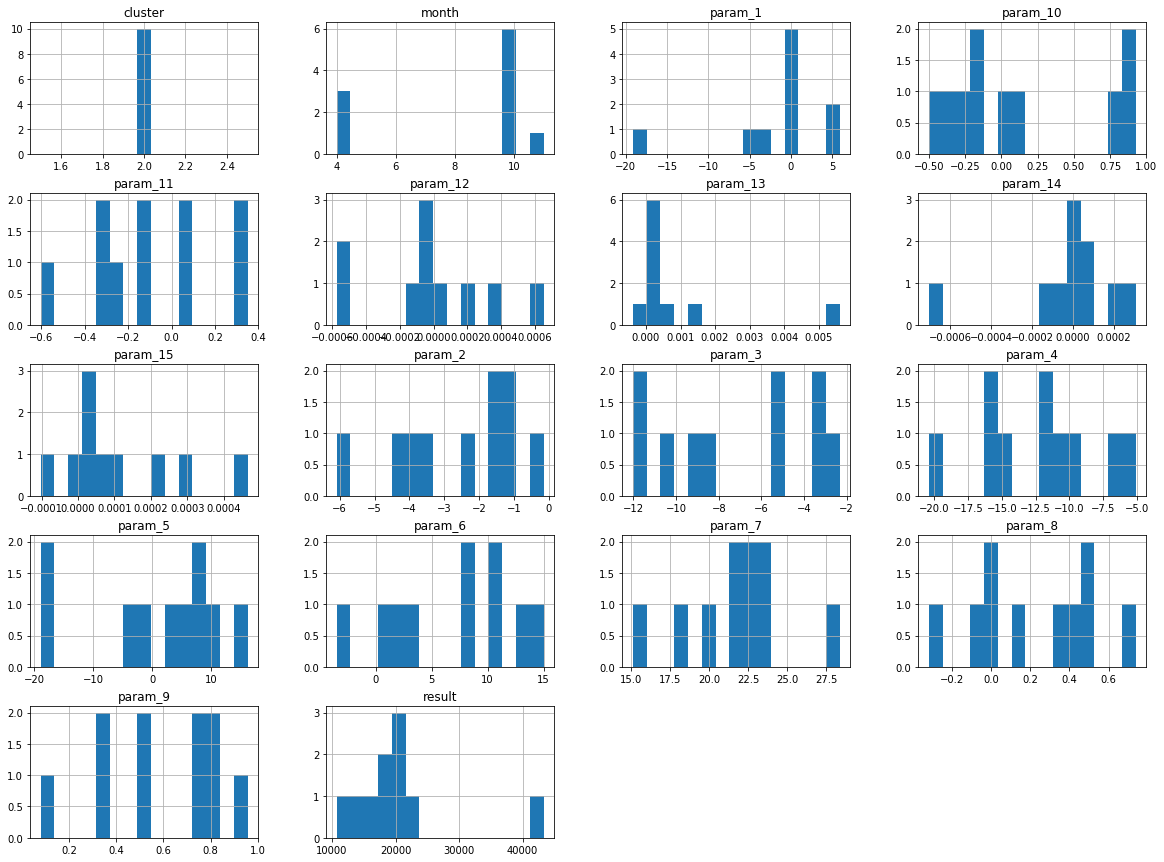

In [226]:

paramsAndRes[paramsAndRes['cluster']==2].hist(bins=15,figsize=(20,15))
plt.show()

In [220]:
paramsAndRes.groupby(['cluster']).describe().result

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,36.0,6963.088786,5485.927243,223.866774,2857.456389,5711.342724,8966.580417,21540.271946
1,1.0,55857.832228,NaN,55857.832228,55857.832228,55857.832228,55857.832228,55857.832228
2,10.0,20341.090430,8881.504778,10726.895697,15984.212827,18964.344635,20922.444519,43319.562998
3,6.0,18328.270858,12147.216941,3490.477938,11510.111988,17371.819722,22083.514424,38525.219031
4,8.0,26363.192414,6802.246417,14532.190727,23565.079865,28083.702843,30362.092733,34736.337342
5,5.0,32496.710168,11251.018765,21482.388774,22906.064990,30641.324384,39404.284592,48049.488102


We need to check upthere if the cluster make sense : look at the std deviation of each param, is it too high ? is there a too big min-max distance for each param to take the mean ?

In [196]:
(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1).groupby(['cluster']).max()-paramsAndRes.drop('month', axis = 1).drop('result', axis = 1).groupby(['cluster']).min()).sum(axis = 1)

cluster
0    125.909610
1      0.000000
2    127.227777
3    104.039267
4    100.651699
5    123.331878
dtype: float64

In [151]:
newParams = []
for i in range(1,16):
    newParams.append(paramsAndRes.groupby(['cluster']).mean()['param_'+str(i)][0])

In [161]:
resACDMod = []
resExpo = []

for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_12.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_12.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)
        resACDMod.append(residualTotalModACD(newParams,initParams(False,True)))
        resExpo.append(residualExpoMovingAverage(0.89))

280
280
280
280
280
275
275
275
280
280
280
280
275
280
280
280
285
285
285
290


In [227]:
print(np.mean(resACDMod))
print(np.mean(resExpo))

30602.9328412
23633.9055676


It seems we cannot perform good clustering, which is more evidence against the robustness of these paramters. Indeed, we could have hoped to find that several sets of parameters are global minima close to a global maximum, and thus, the optimizer can give different sets of optimizer when trained over different set of data. But it seems that parameters are quite far from each others and we cannot even cluster them correctly.

In [234]:
newParams2 = paramsAndRes[paramsAndRes['cluster']==0][paramsAndRes['result'] == np.min(paramsAndRes[paramsAndRes['cluster']==0]['result'])].drop('month', axis = 1).drop('result', axis = 1).drop('cluster', axis = 1).values

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [237]:
resACDMod2 = []
resExpo2 = []

for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_12.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_12.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)
        resACDMod2.append(residualTotalModACD(newParams2,initParams(False,True)))
        resExpo2.append(residualExpoMovingAverage(0.89))

280
280
280
280
280
275
275
275
275
280
280
280
275
280
280
280
285
285
285
290


In [238]:
print(np.mean(resACDMod2))
print(np.mean(resExpo2))

39810.6277113
21169.6438117


# III. Exploratory Analysis :
What is the distribution of waiting time ?
What is the average waiting time for each time frame of the day ?
What is the sampling variance like ?
Is it changing a lot from day to day or is there consistencies ?

In [5]:
def extractOptionData(nbOfDataPoints_, aOptionStrike, data_):
    myTicksOfInterest = []
    myCounter = 0
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
                    
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({
                                     'received': utcToRightTMZ(datetime.utcfromtimestamp(tick['received']/1000000)),
                                     'created' : utcToRightTMZ(datetime.utcfromtimestamp(tick['created']/1000000))
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest

In [232]:
optionData = pd.DataFrame(extractOptionData(200000,335,data2017110110))

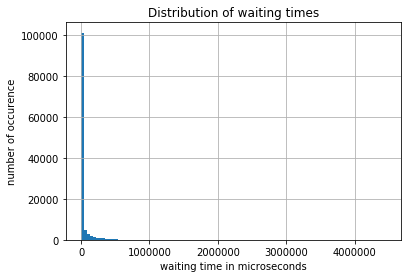

In [233]:
(optionData - optionData.shift())['created'].astype('timedelta64[us]').hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

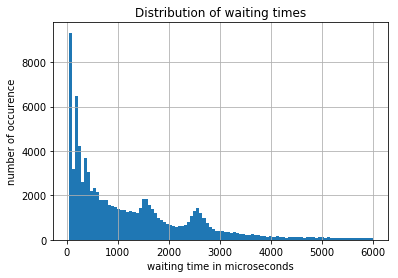

In [234]:
#closer look
dif = (optionData - optionData.shift()).astype('timedelta64[us]')
dif[dif['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

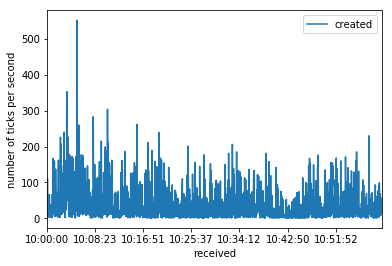

In [235]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M:%S',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per second')
plt.show()
#optionData2 = optionData2.mean(axis=1)

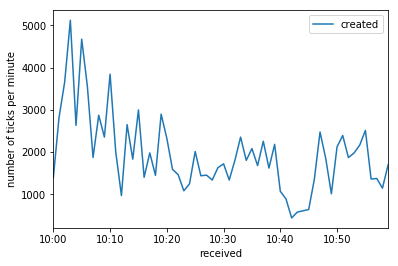

In [236]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per minute')
plt.show()

In [237]:
with gzip.open('data\\2017.11.01\\feeddata_13.json.gz', "rb") as f:
    data2017110113 = json.loads(f.read().decode("ascii")) 

In [242]:
optionData13 = pd.DataFrame(extractOptionData(200000,335,data2017110113))

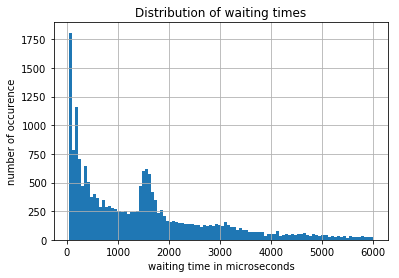

In [243]:
#closer look
dif13 = (optionData13 - optionData13.shift()).astype('timedelta64[us]')
dif13[dif13['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

A few interesting phenomena to investigate : what is this spike of occurences at 1.5ms for both hours?  It happens for both timeframes. 
Also, the market looks less busy at 13:00 than at 10:00. It makes sense.

In [4]:
def residualExpoMovingAverage13(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(extractOptionData(200000,335,data2017110113)):
        counter = counter + 1
        try:
            
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  == 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
        except KeyError:
            print(tick)
            
    return np.mean(errs)

In [247]:
residualExpoMovingAverage13(res_bench2.x)

23632.943847811337

In [248]:
res_bench_test = optimize.minimize(residualExpoMovingAverage13,[res_bench2.x], method='SLSQP', options={'maxiter':30000})

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]


In [249]:
print(res_bench_test)

     fun: 23632.21706746082
     jac: array([ 0.00244141])
 message: 'Optimization terminated successfully.'
    nfev: 17
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.87905185])


In [250]:
print(res_bench2)

     fun: 3315.466151676504
     jac: array([-0.01916504])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.88340882])


#### At first sight the results seem relatively robust, the error is not really different with the version trained on the testing set and the parameter value optimized on the two different sets is not so different. Again, we are just taking a single day with the 10:00-11:00 data as a training set and the 13:00-14:00 data as a testing set.

bigger data analysis

In [6]:
optionDataDay = pd.DataFrame()

for i in range(8,16):
    if i<10:
        stringNumber = '0'+str(i)
    else:
        stringNumber = str(i)
    with gzip.open('data\\2017.11.01\\feeddata_'+stringNumber+'.json.gz', "rb") as f:
        dataTemp = json.loads(f.read().decode("ascii")) 
        optionDataDay =  pd.concat([optionDataDay,pd.DataFrame(extractOptionData(200000,335,dataTemp))])
del dataTemp    
    

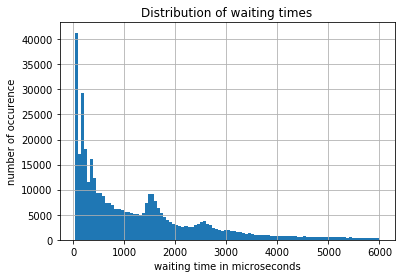

In [13]:
#closer look
difday = (optionDataDay - optionDataDay.shift()).astype('timedelta64[us]')
difday[(difday['created']<6000) & (difday['created']>0)]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

Interestingly enough, it is very similar to subsets.

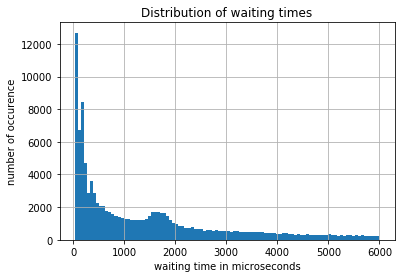

In [14]:
optionDataDay = pd.DataFrame()

for i in range(8,16):
    if i<10:
        stringNumber = '0'+str(i)
    else:
        stringNumber = str(i)
    with gzip.open('data\\2017.11.02\\feeddata_'+stringNumber+'.json.gz', "rb") as f:
        dataTemp = json.loads(f.read().decode("ascii")) 
        optionDataDay =  pd.concat([optionDataDay,pd.DataFrame(extractOptionData(200000,335,dataTemp))])
del dataTemp   

#closer look
difday = (optionDataDay - optionDataDay.shift()).astype('timedelta64[us]')
difday[(difday['created']<6000) & (difday['created']>0)]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()    

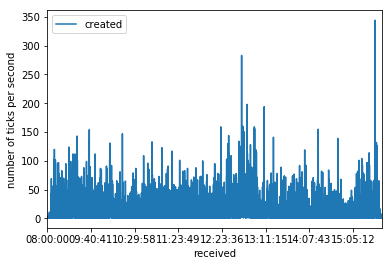

In [18]:
optionDataDay2 = optionDataDay.copy()
optionDataDay2['received'] = optionDataDay2['received'].apply(dt.date.strftime, args=('%H:%M:%S',))
plt.figure(figsize=(20,10))
(optionDataDay2.set_index('received')-optionDataDay2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per second')
plt.show()

In [57]:
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    dataTemp = json.loads(f.read().decode("ascii"))
    dataTemp = pd.DataFrame(dataTemp)[(pd.DataFrame(dataTemp)['book']=='KR4201MB3355') & (pd.DataFrame(dataTemp)['type']=='tick')].drop('book', axis=1).drop('price', axis=1).drop('type', axis=1).drop('volume', axis=1).drop('received', axis=1).reset_index()

In [58]:

dataTemp.drop(list(filter(lambda x: ('ask_p' in x) or ('bid_p' in x), dataTemp.columns)), axis=1, inplace=True)

In [70]:
dataTemp['created'] = (dataTemp['created']/1000000).apply(lambda x: datetime.utcfromtimestamp(x))

In [72]:
dataTemp['created'] = dataTemp['created'].apply(lambda x: utcToRightTMZ(x))

In [73]:
dataTemp['created'] = dataTemp['created'].apply(dt.date.strftime, args=('%H:%M:%S',))
dataTemp.set_index('created', inplace=True)
dataTemp.drop('index', axis=1, inplace=True)

In [84]:
dataTemp = (dataTemp- dataTemp.shift())

In [102]:
dataTemp = dataTemp[(dataTemp!=0).apply(np.sum, axis=1)==1]

In [104]:
dataTemp = dataTemp.groupby(['created']).mean()

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


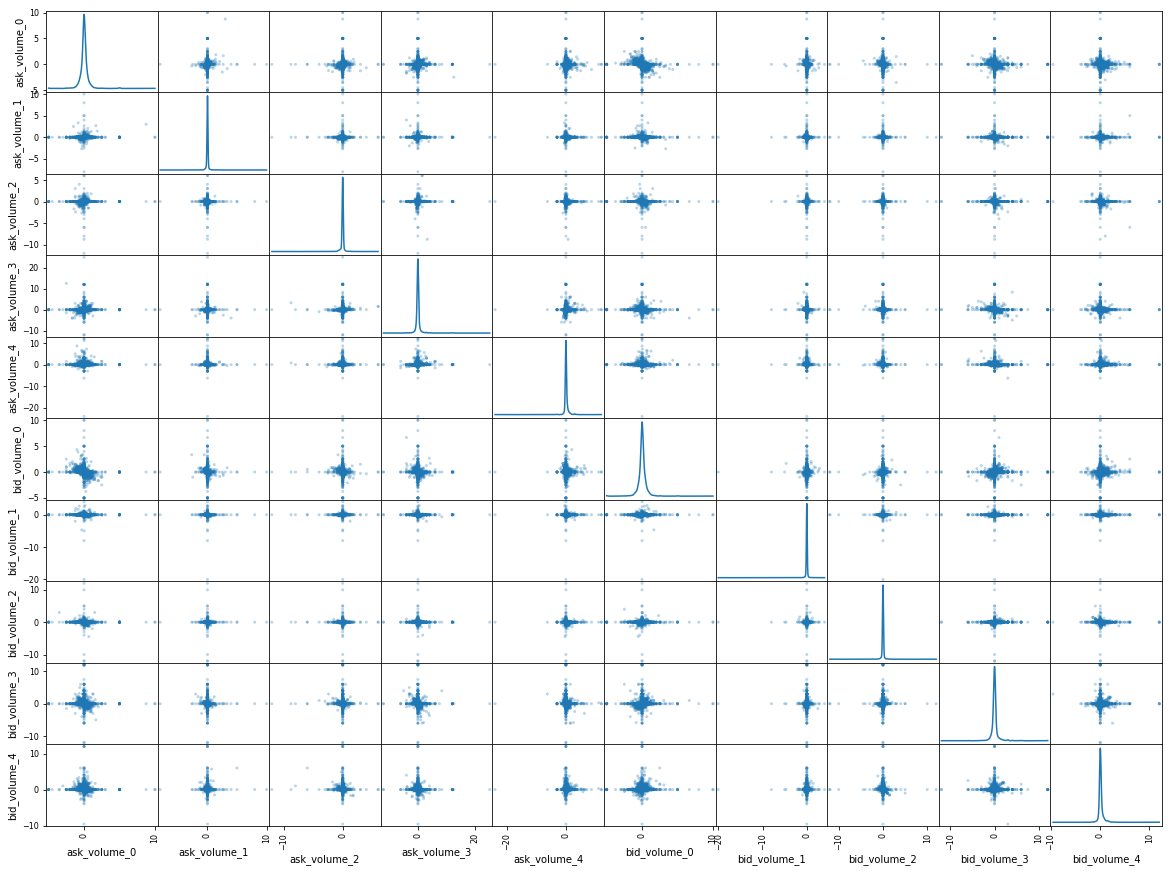

In [110]:
pd.scatter_matrix(dataTemp, alpha = 0.3, figsize = (20,15), diagonal = 'kde')
plt.show()

In [ ]:
#we can add a few things in modACD : binary data of "does the midprice changed" 

# TensorFlow 

We need to rewrite the loss function to work with tensorflow. It is good as it enables me to have easy GPU computation power and potential strong ML tools.

In [15]:
#imports
import tensorflow as tf

if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

We need to format all our data beforehand, the same way we did before, so for a first try, we can use : myDataForRun
However, the data wasn't fully formatted, as the values we are trying to learn are not yet calculated. Additionally, tensorflow requires to be in a numpy array format:
Let's first calculate them, we will need to slighly change our functions : 

In [6]:
def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
 
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
#             if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 my
#                 myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
#                                      'type' : 'lastdone',
#                                      'volume' : tick['volume'],
#                                      'created' : datetime.utcfromtimestamp(tick['created']/1000000)
#                                     })
                
#             elif tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
#                     myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
#                                      'type' : 'lastdone',
#                                      'volume' : tick['volume'],
#                                      'created' : datetime.utcfromtimestamp(tick['created']/1000000)
#                                     })
                    
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    try:
                        myTicksOfInterest = np.append( myTicksOfInterest,(datetime.utcfromtimestamp(tick['created']/1000000)-oldTime).microseconds/1000 )
                    except Exception as e:
                        print(e)
                        pass #pass, not continue, continue switch to the next itirqtion
                    oldTime = datetime.utcfromtimestamp(tick['created']/1000000)
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * round((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

For now, let's only use the same kind of data, to be compared with our models: i.e. only time series or times.

In [7]:
arr = np.empty(shape = (0,0))

In [8]:
arr = np.append([10],[10])

In [9]:
arr = np.vstack((arr,np.array([10,10])))

In [10]:
arr

array([[10, 10],
       [10, 10]])

In [138]:
onlyWaitingTime = np.log(extractInterestingData(6000,whichStrikeAtMoney(data),data))

local variable 'oldTime' referenced before assignment


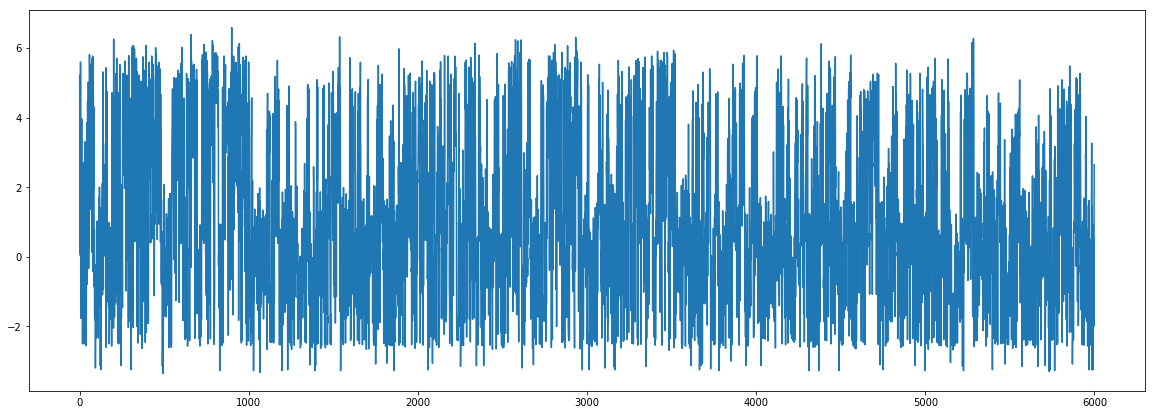

In [140]:
plt.figure(figsize=(20,7))
plt.plot(onlyWaitingTime)
plt.show()

In [326]:
tf.reset_default_graph()

In [327]:
def next_batch(data,batch_size,steps,return_index=False):
        
    # Grab a random starting point for each batch
    rand_start = rand_start = np.random.randint(len(data)-steps, size=(batch_size, 1), dtype = 'int64')

    # Create batch Time Series on occurences (t)
    batch_indices = rand_start + np.arange(0,steps+1)
    
    y_batch = data[batch_indices]

    # Format for RNN
    if return_index:
        return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_indices

    else:
        return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

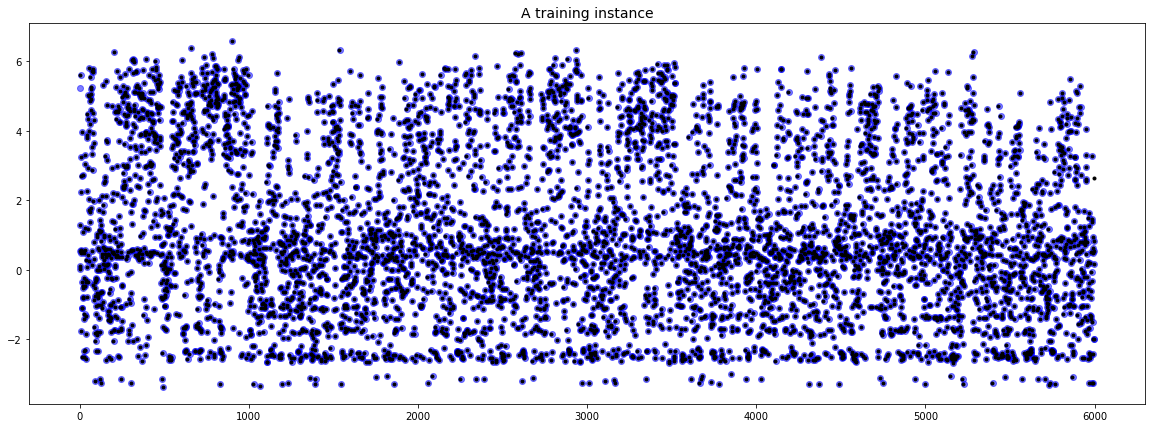

In [328]:
plt.figure(figsize=(20,7))
plt.title("A training instance", fontsize=14)
plt.plot(onlyWaitingTime[:-1], "bo", markersize=6,alpha=0.5 ,label="instance")
plt.plot(onlyWaitingTime[1:], "ko", markersize=3, label="target")
plt.show()

In [329]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0005
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 40000
# Size of the batch of data
batch_size = 1000

# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 10

In [330]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


In [331]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

n_layers = 2

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)
#           for layer in range(n_layers)])


cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=num_neurons)
          for layer in range(n_layers)])

In [332]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [333]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [334]:
init = tf.global_variables_initializer()

In [335]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [336]:
saver = tf.train.Saver()

In [337]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(onlyWaitingTime, batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 500 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 6.84232
500 	MSE: 5.10444
1000 	MSE: 4.99807
1500 	MSE: 5.05228
2000 	MSE: 5.03433
2500 	MSE: 5.0036
3000 	MSE: 5.07005
3500 	MSE: 5.04608
4000 	MSE: 4.89328
4500 	MSE: 4.88104
5000 	MSE: 4.79029
5500 	MSE: 4.80662
6000 	MSE: 4.77747
6500 	MSE: 4.73936
7000 	MSE: 4.70427
7500 	MSE: 4.67116
8000 	MSE: 4.8739
8500 	MSE: 4.84194
9000 	MSE: 4.57389
9500 	MSE: 4.60076
10000 	MSE: 4.73282
10500 	MSE: 4.77275
11000 	MSE: 4.80345
11500 	MSE: 4.59513
12000 	MSE: 4.65846
12500 	MSE: 4.63314
13000 	MSE: 4.50581
13500 	MSE: 4.80383
14000 	MSE: 4.54001
14500 	MSE: 4.68711
15000 	MSE: 4.5564
15500 	MSE: 4.75792
16000 	MSE: 4.7163
16500 	MSE: 4.55214
17000 	MSE: 4.58318
17500 	MSE: 4.51741
18000 	MSE: 4.72156
18500 	MSE: 4.76658
19000 	MSE: 4.56106
19500 	MSE: 4.50715
20000 	MSE: 4.70732
20500 	MSE: 4.77331
21000 	MSE: 4.53274
21500 	MSE: 4.6187
22000 	MSE: 4.67011
22500 	MSE: 4.55615
23000 	MSE: 4.41508
23500 	MSE: 4.66994
24000 	MSE: 4.50414
24500 	MSE: 4.5633
25000 	MSE: 4.56885
25500 	MSE

In [338]:
startTime = np.random.randint(len(onlyWaitingTime)-num_time_steps,size=())
startTime

array(19)

In [339]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   
    X_new = np.array(onlyWaitingTime[:-1][startTime:startTime+num_time_steps].reshape(-1, num_time_steps, num_inputs))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


In [346]:
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(onlyWaitingTime[:-1]):
            counter = counter + 1
            if not first:
                errs.append((waitingTime - ExpectedTime)*(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)

def returnPred(aParam) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(onlyWaitingTime[startTime:startTime+num_time_steps][:-1]):

                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

                pred.append(ExpectedTime)
            
    return pred


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


4.173746030181322


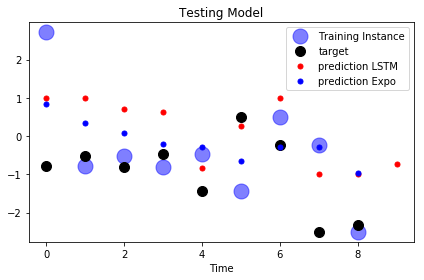

In [347]:
plt.title("Testing Model")

# Training Instance
plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][1:], "ko", markersize=10, label="target")

# Models Prediction
plt.plot(y_pred[0,:,0], "r.", markersize=10, label="prediction LSTM")

plt.plot(returnPred(res_bench2.x), "b.", markersize=10, label="prediction Expo")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

In [348]:
def showOtherGraph():
    startTime = np.random.randint(len(onlyWaitingTime)-num_time_steps,size=())

    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(onlyWaitingTime[:-1][startTime:startTime+num_time_steps].reshape(-1, num_time_steps, num_inputs))
        y_pred = sess.run(outputs, feed_dict={X: X_new})

    plt.title("Testing Model")

    # Training Instance
    plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

    # Target to Predict
    plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][1:], "ko", markersize=10, label="target")

    # Models Prediction
    plt.plot(y_pred[0,:,0], "r.", markersize=10, label="prediction LSTM")

    plt.plot(returnPred(res_bench2.x), "b.", markersize=10, label="prediction Expo")
    plt.xlabel("Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


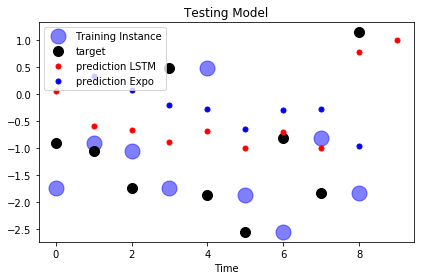

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


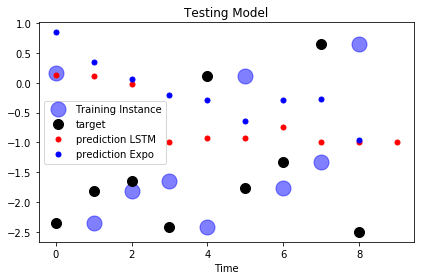

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


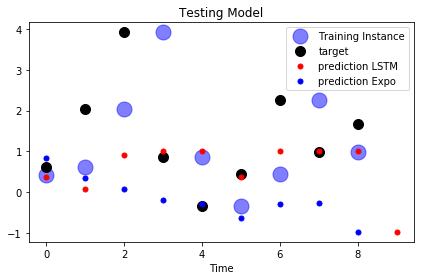

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


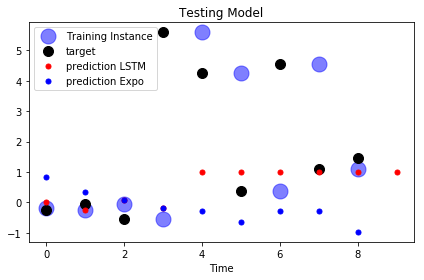

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


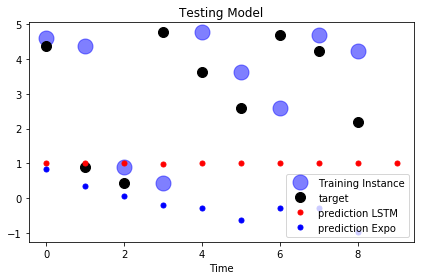

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


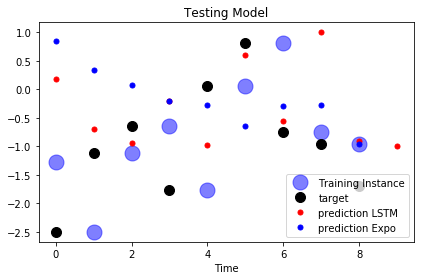

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


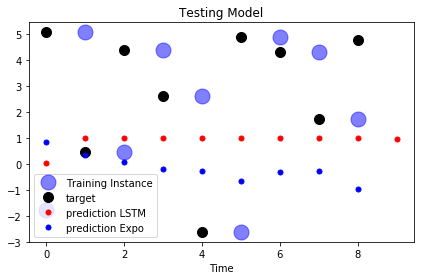

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


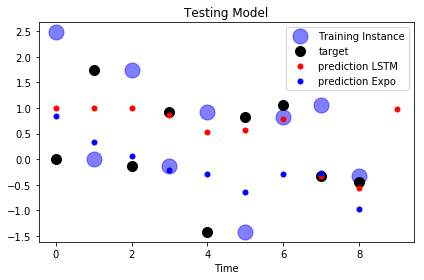

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


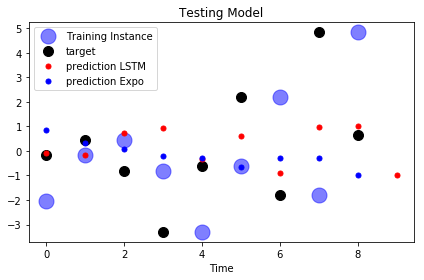

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


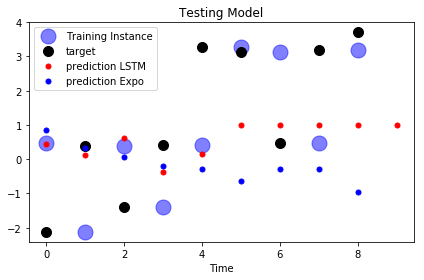

In [349]:
for i in range(0,10):
    showOtherGraph()

In [12]:
def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
    myLastVol = 0
    myLastVolFut = 0
    timeOfTradeFut = 0
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
                    myLastVolFut = 0.99*myLastVol + 0.01*(tick['volume'])
                    timeOfTradeFut = datetime.utcfromtimestamp(tick['created']/1000000)
        
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myLastVol = 0.99*myLastVol + 0.01*(tick['volume'])
                    timeOfTrade = datetime.utcfromtimestamp(tick['created']/1000000)
                    
            elif tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    try:
                        
                        currTime = datetime.utcfromtimestamp(tick['created']/1000000)
                        if len(myTicksOfInterest) == 0 :
                            myTicksOfInterest = np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                          myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) , \
                                                          myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000) ])
                        else:
                            myTicksOfInterest = np.vstack( (myTicksOfInterest,np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                                        myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000), \
                                                                                        myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000) ])) )

                    except Exception as e:
                        print(e)
                        pass #pass, not continue, continue switch to the next itirqtion
                    oldTime = datetime.utcfromtimestamp(tick['created']/1000000)
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * round((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [403]:
WaitingTimeAndTrade = extractInterestingData(6000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment


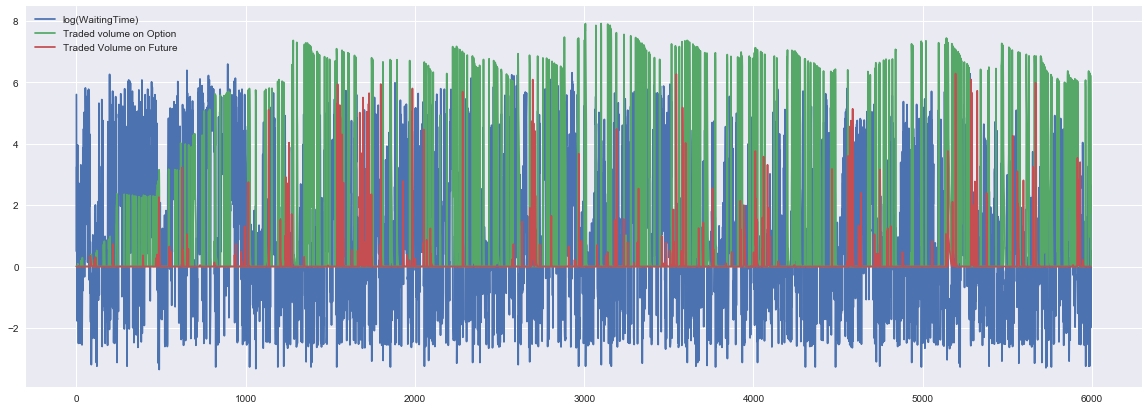

In [638]:
plt.figure(figsize=(20,7))
plt.title('')
plt.plot(WaitingTimeAndTrade)
plt.legend(['log(WaitingTime)','Traded volume on Option','Traded Volume on Future'])
plt.show()

In [445]:
tf.reset_default_graph()

In [438]:
# Just one feature, the time series
num_inputs = 3
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0005
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 25000
# Size of the batch of data
batch_size = 1300

# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 20


X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

n_layers = 3

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)
          for layer in range(n_layers)])

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()

In [439]:
def next_batch(data,batch_size,steps,return_index=False):
    nbLabels = data.shape[1]
    # Grab a random starting point for each batch
    rand_start = rand_start = np.random.randint(len(data)-steps, size=(batch_size,1), dtype = 'int32') #int16 might not be enough

    # Create batch Time Series on occurences (t)
    batch_indices = rand_start + np.arange(0,steps+1)
    
    x_batch = data[batch_indices]
    
    
    # Format for RNN
    if return_index:
        return x_batch[:, :-1, :].reshape(batch_size, steps, nbLabels), x_batch[:, 1:, :1].reshape(batch_size, steps, 1) ,batch_indices

    else:
        return x_batch[:, :-1, :].reshape(batch_size, steps, nbLabels), x_batch[:, 1:, :1].reshape(batch_size, steps, 1)

In [440]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(WaitingTimeAndTrade, batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 500 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 6.94638
500 	MSE: 4.87845
1000 	MSE: 4.74977
1500 	MSE: 4.83041
2000 	MSE: 4.55659
2500 	MSE: 4.43368
3000 	MSE: 4.6198
3500 	MSE: 4.50018
4000 	MSE: 4.33451
4500 	MSE: 4.53201
5000 	MSE: 4.31327
5500 	MSE: 4.3353
6000 	MSE: 4.52492
6500 	MSE: 4.47529
7000 	MSE: 4.39792
7500 	MSE: 4.42227
8000 	MSE: 4.41975
8500 	MSE: 4.20771
9000 	MSE: 4.34425
9500 	MSE: 4.29697
10000 	MSE: 4.44866
10500 	MSE: 4.33448
11000 	MSE: 4.37915
11500 	MSE: 4.39161
12000 	MSE: 4.32952
12500 	MSE: 4.42304
13000 	MSE: 4.21063
13500 	MSE: 4.333
14000 	MSE: 4.45564
14500 	MSE: 4.4483
15000 	MSE: 4.14368
15500 	MSE: 4.26566
16000 	MSE: 4.1251
16500 	MSE: 4.22354
17000 	MSE: 4.28305
17500 	MSE: 4.26717
18000 	MSE: 4.28774
18500 	MSE: 4.4313
19000 	MSE: 4.26659
19500 	MSE: 4.28151
20000 	MSE: 4.31428
20500 	MSE: 4.27799
21000 	MSE: 4.3058
21500 	MSE: 4.10079
22000 	MSE: 4.22338
22500 	MSE: 4.0997
23000 	MSE: 4.21762
23500 	MSE: 4.22344
24000 	MSE: 4.20992
24500 	MSE: 4.21569


In [454]:
WaitingTimeAndTrade[:,0]

array([ 5.59795889,  0.48735227,  3.24761876, ..., -1.99510039,
        0.83160392,  2.6509859 ])

In [455]:
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade[:,0]):
            counter = counter + 1
            if not first:
                errs.append((waitingTime - ExpectedTime)*(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)

def returnPred(aParam) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade[:,0][startTime:startTime+num_time_steps][:-1]):

                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

                pred.append(ExpectedTime)
            
    return pred


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


4.16994156588581


In [516]:
WaitingTimeAndTrade[startTime:startTime+num_time_steps,:1]

array([[ -1.42295835e+00,   7.40358082e-12,   1.54334636e-03],
       [  4.89806257e-01,   1.44768218e-12,   3.01783024e-04],
       [ -2.43346259e-01,   6.60977009e-13,   1.37786901e-04],
       [ -2.50103603e+00,   6.08939584e-13,   1.26939208e-04],
       [ -2.33304430e+00,   5.52646777e-13,   1.15204441e-04],
       [ -1.26940061e+00,   4.17263976e-13,   8.69826172e-05],
       [  1.19179900e+00,   1.54981251e-14,   3.23073058e-06],
       [  3.30677681e+00,   2.16442574e-26,   4.51194991e-18],
       [  3.02761846e+00,   1.89001000e-01,   4.86465233e-27],
       [  5.83890195e-01,   3.14611140e-02,   8.09770220e-28],
       [ -4.78035801e-01,   1.69243313e-02,   4.35611385e-28],
       [ -2.29263476e+00,   1.52984621e-02,   3.93763521e-28],
       [ -1.32425897e+00,   1.17253399e-02,   3.01795769e-28],
       [ -2.81037530e-01,   5.51103423e-03,   1.41847215e-28],
       [ -2.55104645e+00,   5.09751062e-03,   1.31203628e-28],
       [ -1.83258146e+00,   4.34381201e-03,   1.1180435

In [517]:
def showOtherGraph2():
    startTime = np.random.randint(len(WaitingTimeAndTrade)-num_time_steps,size=())
    nbLabels = WaitingTimeAndTrade.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(WaitingTimeAndTrade[startTime:startTime+num_time_steps].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})

    plt.title("Testing Model")

    # Training Instance
    plt.plot(WaitingTimeAndTrade[startTime:startTime+num_time_steps,:1][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

    # Target to Predict
    plt.plot(WaitingTimeAndTrade[startTime:startTime+num_time_steps,:1][1:], "ko", markersize=10, label="target")

    # Models Prediction
    plt.plot(y_pred[0,:,0][:-1], "r.", markersize=10, label="prediction LSTM")

    plt.plot(returnPred(res_bench2.x), "b.", markersize=10, label="prediction Expo")
    plt.xlabel("Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


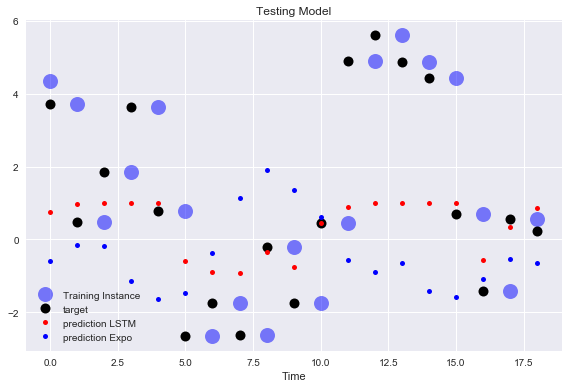

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


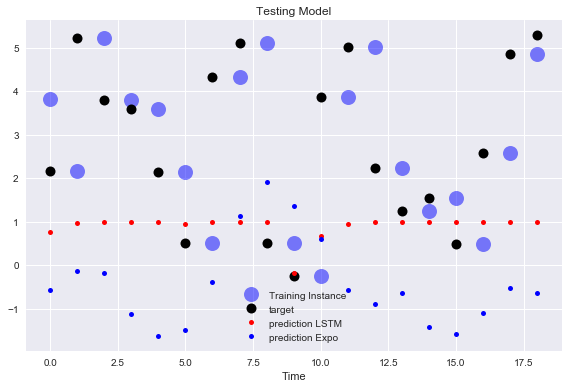

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


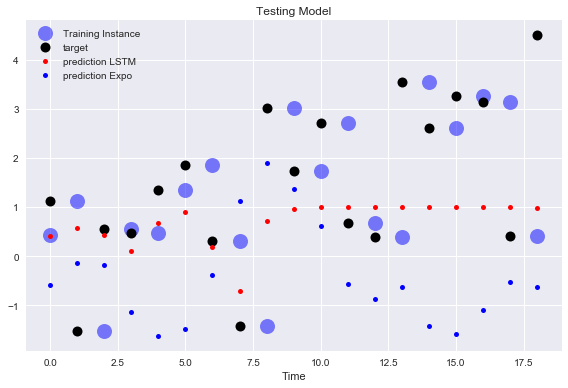

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


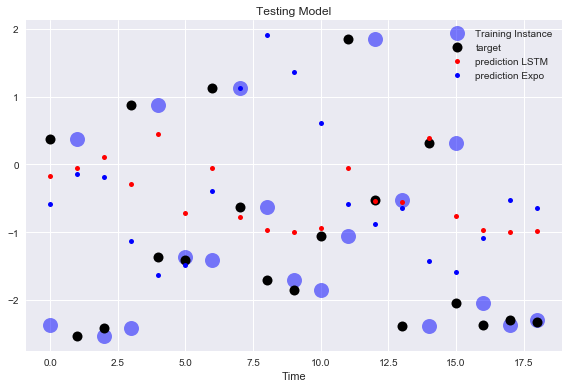

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


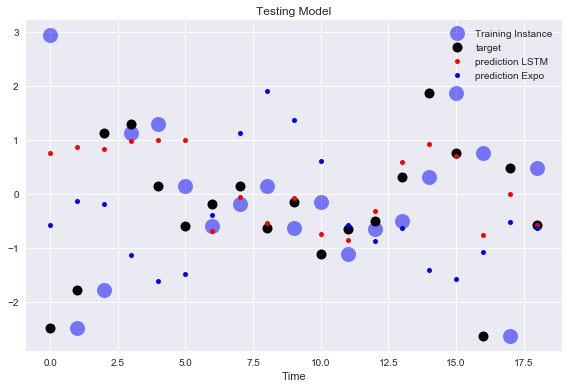

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


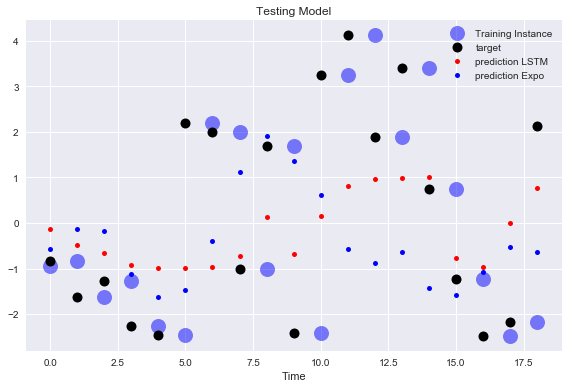

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


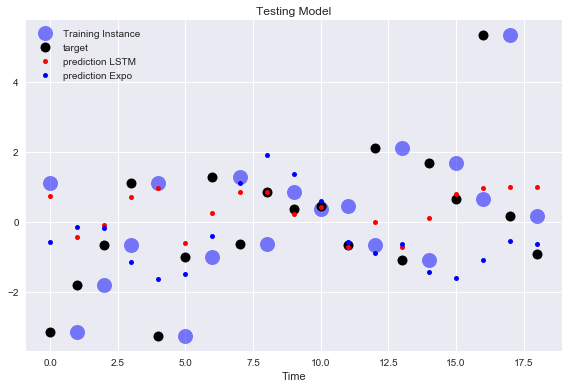

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


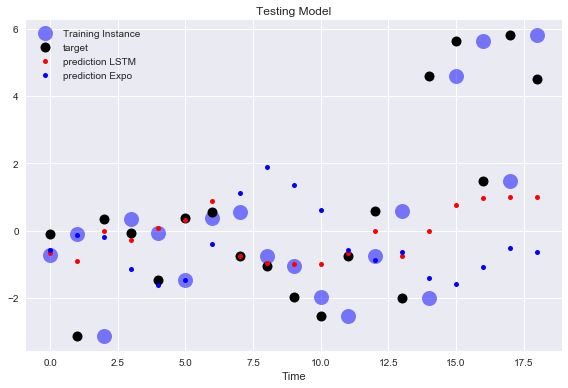

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


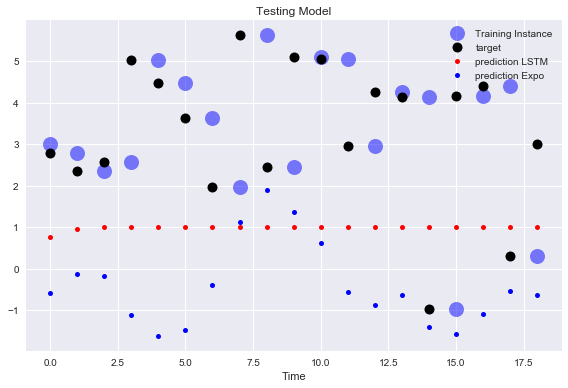

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


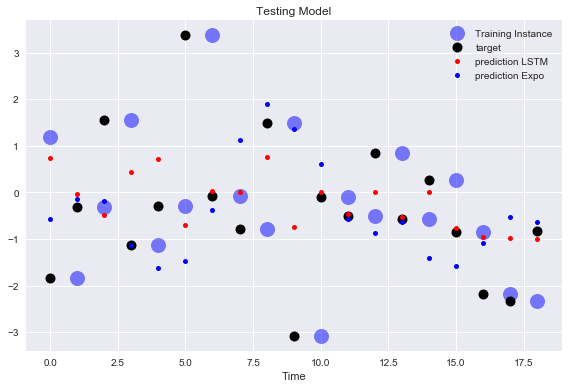

In [639]:
for i in range(0,10):
    showOtherGraph2()

In [461]:
tf.reset_default_graph()

In [462]:
#after reviewing the data: the problem seems to be the shocks. When they occur, they create a huge shock on the MLS estimator, forcing it to adjust to this shock more than to fit the remaining of the data

In [16]:
# Just one feature, the time series
num_inputs = 3
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0005
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 25000
# Size of the batch of data
batch_size = 1300

# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 20


X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

n_layers = 3

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)
          for layer in range(n_layers)])

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.abs(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()

In [464]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(WaitingTimeAndTrade, batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 500 == 0:
            
            ase = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tASE:", ase)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	ASE: 2.07538
500 	ASE: 1.75585
1000 	ASE: 1.72641
1500 	ASE: 1.70139
2000 	ASE: 1.67554
2500 	ASE: 1.68271
3000 	ASE: 1.63648
3500 	ASE: 1.64697
4000 	ASE: 1.62871
4500 	ASE: 1.6209
5000 	ASE: 1.63078
5500 	ASE: 1.61684
6000 	ASE: 1.65641
6500 	ASE: 1.62024
7000 	ASE: 1.63166
7500 	ASE: 1.59327
8000 	ASE: 1.57534
8500 	ASE: 1.60231
9000 	ASE: 1.62704
9500 	ASE: 1.58298
10000 	ASE: 1.59722
10500 	ASE: 1.60435
11000 	ASE: 1.61132
11500 	ASE: 1.61293
12000 	ASE: 1.57814
12500 	ASE: 1.5897
13000 	ASE: 1.57682
13500 	ASE: 1.57214
14000 	ASE: 1.58501
14500 	ASE: 1.60984
15000 	ASE: 1.57556
15500 	ASE: 1.57147
16000 	ASE: 1.59103
16500 	ASE: 1.57356
17000 	ASE: 1.54113
17500 	ASE: 1.57028
18000 	ASE: 1.58038
18500 	ASE: 1.56522
19000 	ASE: 1.58492
19500 	ASE: 1.5657
20000 	ASE: 1.58691
20500 	ASE: 1.54897
21000 	ASE: 1.54988
21500 	ASE: 1.56787
22000 	ASE: 1.54048
22500 	ASE: 1.55478
23000 	ASE: 1.54863
23500 	ASE: 1.54271
24000 	ASE: 1.54721
24500 	ASE: 1.55902


In [519]:
def residualExpoMovingAverageABS(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade[:,0]):
            counter = counter + 1
            if not first:
                errs.append(np.abs(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2 = optimize.minimize(residualExpoMovingAverageABS,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


1.6065681643581136


INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


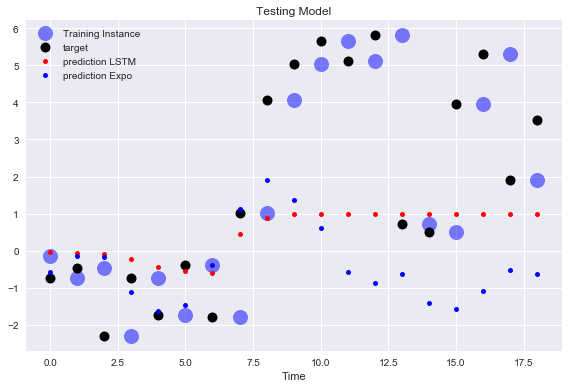

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


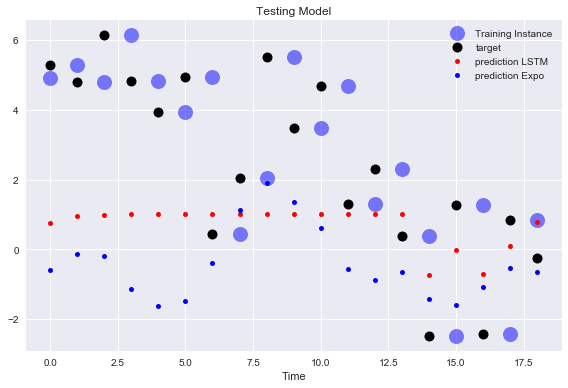

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


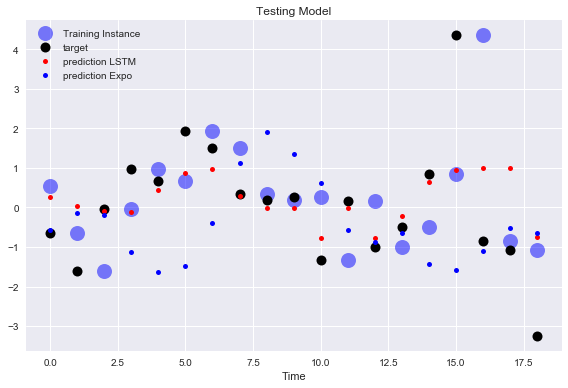

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


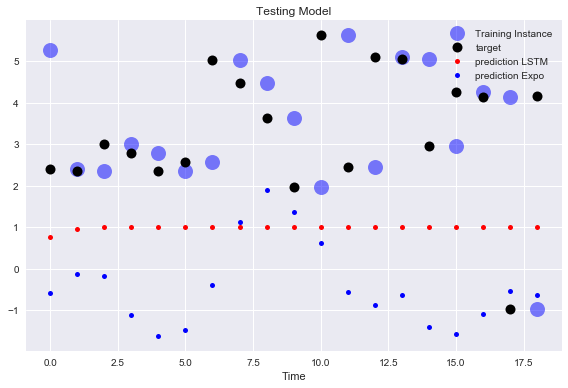

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


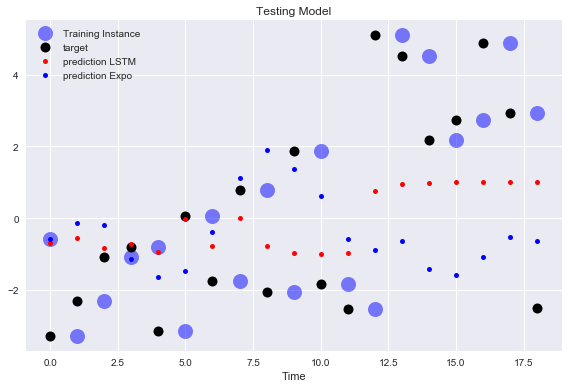

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


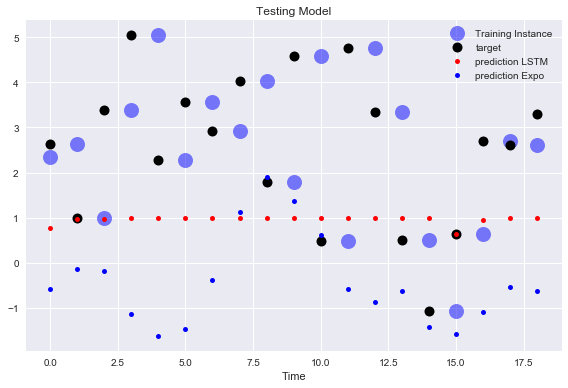

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


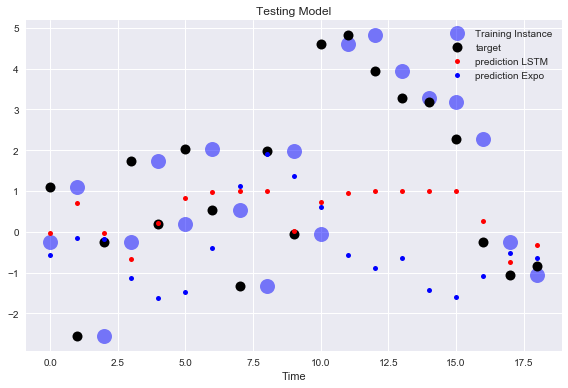

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


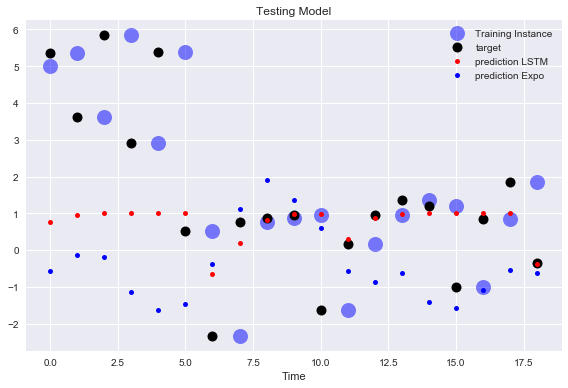

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


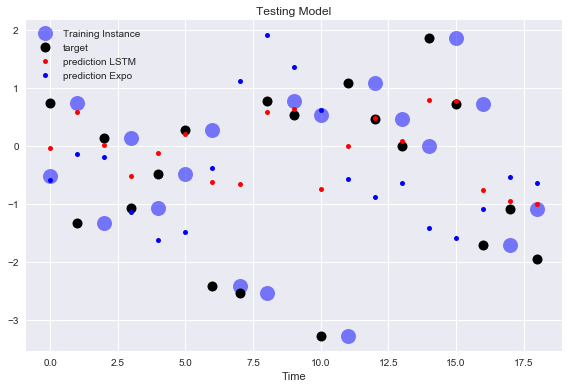

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


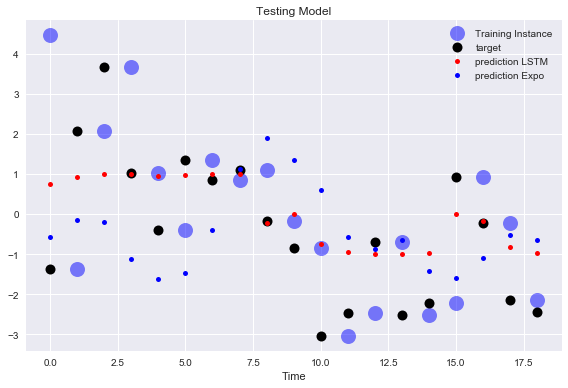

In [640]:
for i in range(0,10):
    showOtherGraph2()

In [677]:

WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment


In [678]:
def residualExpoMovingAverageABS_testingSet(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0]):
            counter = counter + 1
            if not first:
                errs.append(np.abs(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2_test = optimize.minimize(residualExpoMovingAverageABS_testingSet,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2_test.fun)


def returnPred_test(aParam) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime:startTime+num_time_steps][:-1]):

                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

                pred.append(ExpectedTime)
            
    return pred


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


1.5180044207271797


In [9]:
def showOtherGraph_test():
    startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps,size=())
    nbLabels = WaitingTimeAndTrade_test.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
    print(np.average(np.abs(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))
    print(np.average(np.abs(returnPred_test(res_bench2_test.x) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))    
#     plt.title("Testing Model")

#     # Training Instance
#     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

#     # Target to Predict
#     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:], "ko", markersize=10, label="target")

#     # Models Prediction
#     plt.plot(y_pred[0,:,0][:-1], "r.", markersize=10, label="prediction LSTM")

#     plt.plot(returnPred_test(res_bench2_test.x), "b.", markersize=10, label="prediction Expo")
#     plt.xlabel("Time")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    
    return np.average(np.abs(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
            np.average(np.abs(returnPred_test(res_bench2_test.x) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [680]:
error_lstm_dist = np.empty(shape = (0,0))
error_expo_dist = np.empty(shape = (0,0))
for i in range(0,200):
    error_lstm, error_expo = showOtherGraph_test()
    error_lstm_dist= np.append(error_lstm_dist,error_lstm)
    error_expo_dist = np.append(error_expo_dist,error_expo)

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.11182965184
2.97989798836
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.01386454362
1.45992920928
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.3249626834
1.59571634607
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.66340047677
1.994093709
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.775681952143
1.16504769448
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.08172242054
2.44430748959
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.51027528894
2.29196119226
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.17544116905
3.04017113117
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.771543599677
1.336935007
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.26008469052
1.26744577026
INFO:tensorflow:Restoring parameters from ./rnn_time_series_mod

2.48827124202
3.60438300755
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.920950536727
1.15791582312
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.92461414072
2.29968674802
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.88684511605
1.92213112567
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.481247123478
1.03080704325
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.20019289979
1.94457863921
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.1119378533
4.31458778878
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.39668784181
3.6075287459
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.08430792806
2.12942049938
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.00142279998
3.19757472803
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.37251203219
1.27066686523
INFO:tensorflow:Restoring parame

0.889547470999
1.33901695216
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.60924276892
1.77921760959
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.1704062139
1.60793379729
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.37039256304
3.02585771846
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.72521865413
2.31833050667
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.89645937424
2.4256621892
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.37636844772
3.28315557156
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.00348720944
1.23292175841
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.14936185276
2.49674896667
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.56703937605
3.81152767273
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.67156286928
2.39425781083
INFO:tensorflow:Restoring paramet

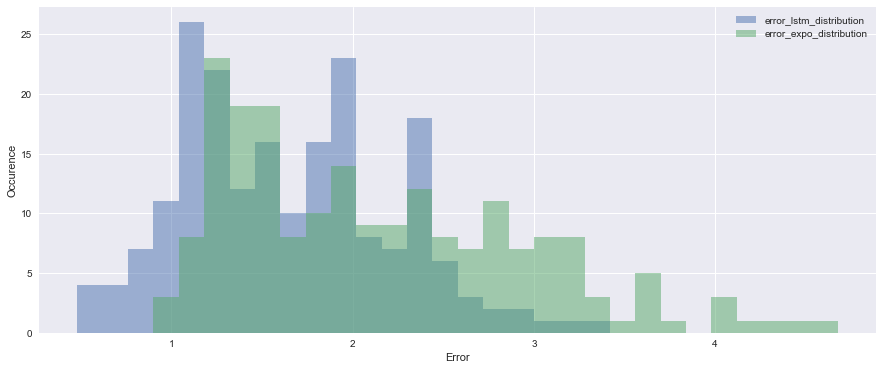

In [681]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=30,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

In [682]:
df_testRest.describe()

,error_lstm_distribution,error_expo_distribution
count,200.000000,200.000000
mean,1.642543,2.135923
std,0.580574,0.812240
min,0.481247,0.972252
25%,1.169591,1.442347
50%,1.578294,1.975897
75%,2.009711,2.739730
max,3.293621,4.679135


In [667]:
#now completely different dataset : 

In [683]:
with gzip.open('data\\2017.10.12\\feeddata_10.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))

In [684]:
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' 

In [8]:
def residualExpoMovingAverageABS_testingSet(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0]):
            counter = counter + 1
            if not first:
                errs.append(np.abs(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

# res_bench2_test = optimize.minimize(residualExpoMovingAverageABS_testingSet,[1], method='SLSQP', options={'maxiter':30000})
# print(res_bench2_test.fun)


def returnPred_test(aParam) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime:startTime+num_time_steps][:-1]):

                ExpectWaitingTimeAndTrade_testedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

                pred.append(ExpectedTime)
            
    return pred


In [686]:
error_lstm_dist = np.empty(shape = (0,0))
error_expo_dist = np.empty(shape = (0,0))
for i in range(0,200):
    error_lstm, error_expo = showOtherGraph_test()
    error_lstm_dist= np.append(error_lstm_dist,error_lstm)
    error_expo_dist = np.append(error_expo_dist,error_expo)

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.842714551675
0.666774304377
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.70099311655
3.29233588893
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.5251072781
1.58339083702
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.73768072493
1.84082990306
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.76108869193
2.11774869077
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.966373019416
0.9251463235
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.93888983067
1.71395617697
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.20360597281
1.36459275182
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.23144787176
2.90580256324
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.16933668554
2.08779285932
INFO:tensorflow:Restoring parameters from ./rnn_time_series

2.11112142788
2.63538390872
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.14735460305
2.61872392585
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.03307599299
2.40307562998
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.766037734
1.5557690676
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.8439196535
2.40767366388
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.1172572474
1.03751036921
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.20176864162
1.48089089761
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.31748426803
1.07221505538
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.09458308223
2.32525190235
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.85823103596
1.69567358851
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.46740869314
1.59011301037
INFO:tensorflow:Restoring parameters 

2.14212992303
2.70209786776
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.40596872819
2.77603662678
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.60565429425
1.46944220485
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.71148948115
2.01889921281
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.29034182729
2.40630986198
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.90806371251
2.18438725443
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.51633186459
1.64447164266
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.06832742256
0.935242140173
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.71742095927
3.54257313502
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.33511049364
1.43651688773
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.43395111813
3.17831632268
INFO:tensorflow:Restoring param

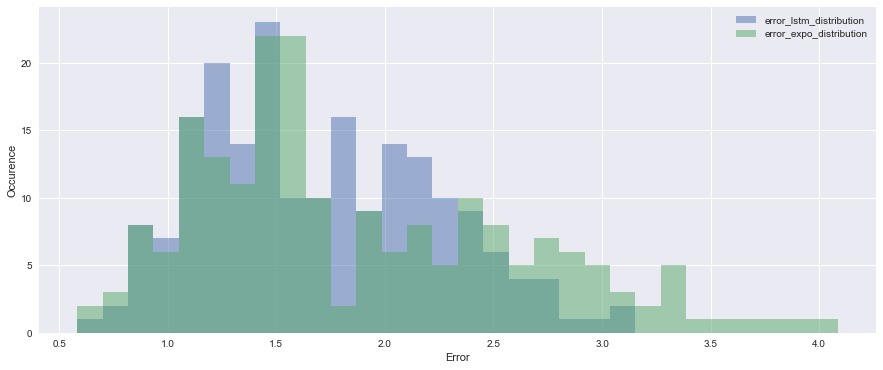

In [687]:
#the expo hasn() been fitted to the new data:

plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=30,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

In [688]:
res_bench2_test = optimize.minimize(residualExpoMovingAverageABS_testingSet,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2_test.fun)
#the expo has been fitted to the new data:
error_lstm_dist = np.empty(shape = (0,0))
error_expo_dist = np.empty(shape = (0,0))
for i in range(0,200):
    error_lstm, error_expo = showOtherGraph_test()
    error_lstm_dist= np.append(error_lstm_dist,error_lstm)
    error_expo_dist = np.append(error_expo_dist,error_expo)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


1.4359912256033285
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.39876900727
3.13773358998
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.417316227
2.9600443152
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.01681184555
3.63742634205
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.76428999432
2.44292947917
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.55595832107
1.40817661534
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.69382169522
1.85088412959
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.73125980761
1.61255378944
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.968438750738
0.864138980921
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.22123149079
1.07500451703
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.29840718824
1.32650452658
INFO:tensorflow:Restoring parameters from 

0.895748517888
0.948407705735
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.11128991896
2.48770788416
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.60368961018
1.4613076351
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.95633154091
2.06483518008
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.94160231421
1.72714686117
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.555008633
1.63188250357
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.07970029852
2.0014488002
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.22290446536
1.29947006187
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.95982615724
2.65292041641
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.03585008139
2.37551648761
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.1437713652
1.0294595994
INFO:tensorflow:Restoring parameters

1.2128524733
1.16790111997
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.54579099745
1.30584858648
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.54087743525
3.0362714271
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.9176513865
2.13332946374
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.48907582759
1.57445339565
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.67844184214
1.44105508169
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.30753269294
1.35597008944
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.874112537735
0.826354955
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.15339917839
0.995980676434
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.77038104426
1.43687883338
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.25727452529
1.43552014655
INFO:tensorflow:Restoring parameter

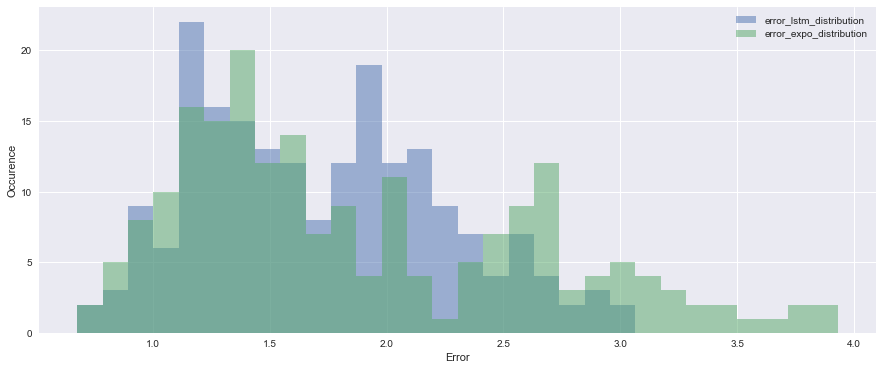

In [690]:
#the expo hasn been fitted to the new data:

plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=30,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

In [692]:
with gzip.open('data\\2017.10.20\\feeddata_12.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))
    
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

error_lstm_dist = np.empty(shape = (0,0))
error_expo_dist = np.empty(shape = (0,0))
for i in range(0,2000):
    error_lstm, error_expo = showOtherGraph_test()
    error_lstm_dist= np.append(error_lstm_dist,error_lstm)
    error_expo_dist = np.append(error_expo_dist,error_expo)
    


local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'ti

2.69973591086
3.11079482688
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.2549343297
2.0901137241
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.98317333813
1.55847260979
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.14964992052
1.99512481518
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.34709343745
3.81112714804
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.28517948764
3.83336094556
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.50737504314
1.51071188211
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.32981450842
2.70945522877
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.55788856775
2.74832405125
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.39037793104
1.19876370614
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.095117553
4.98786353095
INFO:tensorflow:Restoring parameters

2.37912827378
2.8921650603
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.12108038435
2.07173461575
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.09479834342
2.40402641396
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.69463507217
4.31076132519
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.889250502678
0.904053619302
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.22551245691
1.10260373548
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.10359186146
0.963011764494
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.78071826614
1.81357993147
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.02325068679
3.3535607711
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.38218152761
1.3304217328
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.985721177601
1.03182017894
INFO:tensorflow:Restoring param

1.39750795077
1.18224616553
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.67815413321
2.74278403721
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.02195820901
2.08084664786
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.05476232364
4.74383433968
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.77565698251
2.97049525149
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.742603094245
0.953790369576
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.99602511414
1.98185981526
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.48804698793
1.2516276054
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.59016331005
1.59399731566
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.67428779479
1.45970783392
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.97288998497
2.2131763359
INFO:tensorflow:Restoring parame

2.35442304315
2.60927079829
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.31668762165
3.92388552239
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.61056778996
4.59582570729
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.22473447194
1.02605580124
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.915777956419
0.86222748061
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.9954856859
1.64060129669
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.22314591991
2.72651000979
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.42475879084
1.43807633431
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.99228515506
4.53690710468
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.70006921411
1.65596521807
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.36521161485
3.00645929796
INFO:tensorflow:Restoring parame

0.821740235783
0.999288064403
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.31768133413
2.38236518511
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.5244095591
2.59752212492
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.30243718924
1.31116379642
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.21313389162
2.56901649653
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.96059680694
3.32124722594
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.833892709818
0.909457836576
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.40084781283
1.13012635415
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.05185380005
3.68854793802
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.62167558812
1.90020668991
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.06411210788
1.75863062528
INFO:tensorflow:Restoring par

3.82910386048
4.26774031627
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.15346088232
1.19983439095
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.48706476309
5.29660812481
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.1042577907
1.97959371839
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.4729795284
2.85466818883
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.6189455499
3.08645309304
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.57687879596
2.74111866888
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.45741031433
1.04795731586
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.39370446475
2.67696220151
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.10117129816
2.81435765543
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.63522815269
1.80714178143
INFO:tensorflow:Restoring parameter

3.86831315564
4.09597951488
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.24752117154
1.38648786501
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.48950583315
4.07004065601
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.5831136645
2.9354140501
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.86888172171
2.30084028863
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.76894825199
3.16213542654
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.27592894322
2.65587807567
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.93287381444
3.53322658056
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.41951183723
1.29742903103
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.46377169359
1.57465082902
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.92511643784
1.51906213221
INFO:tensorflow:Restoring paramete

1.80642232981
1.82875001623
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.54127399056
1.54673416688
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.17524165323
3.78593881379
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.36759047522
1.15272290664
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.65348577402
2.69812214042
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.10062793465
3.23652255727
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.77579084332
3.1469875934
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.13477985558
3.4057281517
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.31651566134
2.26753369282
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.6876161009
1.64416275194
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.96019078325
2.20814505887
INFO:tensorflow:Restoring parameter

4.21526154603
4.64691362199
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.13582037013
1.18970891975
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.42493705542
4.22185916176
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.85555460905
3.56055275018
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.63606001695
5.62131794056
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.22902020488
0.989571335527
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.51691247513
1.40617331281
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.25598975988
1.19417112301
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.26565329454
2.71806480566
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.37991092743
1.1596615624
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.27566836112
3.89331437455
INFO:tensorflow:Restoring parame

1.11561979229
1.28617867215
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.14447233284
0.980087745606
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.42873424607
1.54293243338
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.6690438463
4.03839356811
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.38452121448
2.73588181541
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.10142738695
2.22797795696
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.2878893643
3.00693886735
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.87751713436
2.05905419074
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.53613803858
4.34104841661
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.16137857177
3.55146623978
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.789699661994
0.847136247619
INFO:tensorflow:Restoring param

3.67053690144
4.34455136233
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.62305128149
4.24135765596
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.48017613824
3.05308164883
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.02628341522
4.86369394912
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.05489646819
2.21690557364
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.93141434565
3.68307746646
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.66439684152
3.05396540142
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.80454629856
3.43736013539
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.01225540229
4.99751331648
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.63082685771
1.51737450134
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.5349971988
1.42709536464
INFO:tensorflow:Restoring paramet

1.35978183661
1.35732441361
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.85900795405
1.06098945965
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.96047814255
4.90027042125
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.57327652503
2.54261584018
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.13534334237
3.53940802047
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.14873816704
1.77506135709
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.2087339166
3.81101534155
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.34231337362
2.62931811744
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.55022811445
2.80247013462
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.52823269712
4.10474175265
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.32244163219
2.01164482771
INFO:tensorflow:Restoring paramet

1.81923701788
2.07412839075
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.15325339611
4.75715736852
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.04561038986
3.17758136287
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.73251830682
1.53879369858
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.30106275869
3.91451797426
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.41448389126
1.36838326516
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.41163845103
1.16298158261
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.18321174589
1.93958887966
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.64026180544
3.00397431914
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.64347175948
1.50974349774
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.19082171095
2.6587063278
INFO:tensorflow:Restoring paramet

3.3328144564
3.65910187474
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.08644281625
4.97512188028
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.08155024091
4.88439828656
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.23237949755
2.79251260563
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.78861969465
3.17596723636
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.89155869079
1.89993158512
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.91145134125
4.67937590714
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.06999815406
2.7012696994
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.27405575925
0.979048317434
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.98249322939
3.49671704662
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.6217552381
4.25046972354
INFO:tensorflow:Restoring paramete

1.88234467219
2.13776580896
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.3128094645
1.43008263967
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.2718877801
3.8644333741
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.639701745
1.41228839334
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.02237127676
2.2688952379
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.02991778999
2.99331327519
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.34088981921
1.49869646842
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.09072595335
2.4656208345
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.4466847271
1.13137586388
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.07056386343
1.74217631363
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.60470697753
1.58609547733
INFO:tensorflow:Restoring parameters fro

3.53952309199
4.42093794042
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.11736862166
2.47364239122
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.45657802597
1.51828665078
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.33247847247
1.47415994366
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.0695008425
3.99872947771
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.51239852633
4.45195980041
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.98673311878
2.08572382555
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.43660195278
4.15458598957
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.7083941969
1.56809425771
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.21157282773
1.2032417333
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.24251430541
3.72807027821
INFO:tensorflow:Restoring parameter

0.723303553104
0.937435530415
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.52858760484
3.11568650592
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.986921702632
1.01438787342
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.75457632997
2.07886924301
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.98682381795
3.02540936714
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.63920833786
3.95291323591
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.64352601004
3.10411084452
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.955115927483
0.958901450745
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.03978081756
3.49837990824
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.67123624428
2.74001166078
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.08725889015
1.39047267209
INFO:tensorflow:Restoring p

3.8048376273
4.73396652523
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.3508290196
2.79888291686
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.64442721349
1.19902661013
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.93681022922
0.766623211773
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.6284370644
1.53796966741
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.01194478722
2.32624866681
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.45149292867
3.03486245594
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.38646293021
3.71465488679
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.01870175574
0.999243901208
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.40046994624
1.41845007119
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.5640326992
1.48713789494
INFO:tensorflow:Restoring paramete

1.65895802697
1.70883975491
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.04452419703
2.15458833512
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.80703592807
3.27984187588
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.11089585769
1.08289882648
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.25952354122
1.23911149112
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.13063977325
1.14477783639
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.45723258025
1.56028682268
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.20750705414
1.25873522845
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.22661979432
5.17732707597
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.80162893382
5.78688077147
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.916894233177
0.906937315779
INFO:tensorflow:Restoring para

2.72823370981
3.00861607261
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.30937679164
2.54663324349
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.11455397634
1.37044252343
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.69169615826
1.92075775145
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.32750127748
1.22791300507
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.25214533741
3.93009665179
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.48405091297
4.00501740105
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.32913995349
2.28114465128
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.74492683143
1.72077994671
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.91275390812
2.13174458432
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.49824706052
1.45930715306
INFO:tensorflow:Restoring parame

2.28719452331
2.42210723865
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.97175774972
1.7818855417
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.13397823354
2.5061173344
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.0292537196
2.13813729138
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.44932567792
1.57060818383
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.80620912849
3.33188854921
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.2721239906
1.10708243515
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.44089517115
4.28410854212
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.88817830988
1.97312178707
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.60622075705
1.4488892592
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.36397678255
1.19868497923
INFO:tensorflow:Restoring parameters 

3.0623778493
3.26576466034
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.67367713859
3.83340404286
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.48605588152
2.79163463527
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.90090328464
3.55864540133
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.39866495686
2.80082784786
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.18773421811
2.04401615093
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.51105335023
4.23862209764
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.74647990556
4.71602215285
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.19804752068
1.35472211636
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.37788565434
1.40073124414
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.23782031398
2.68573950229
INFO:tensorflow:Restoring paramet

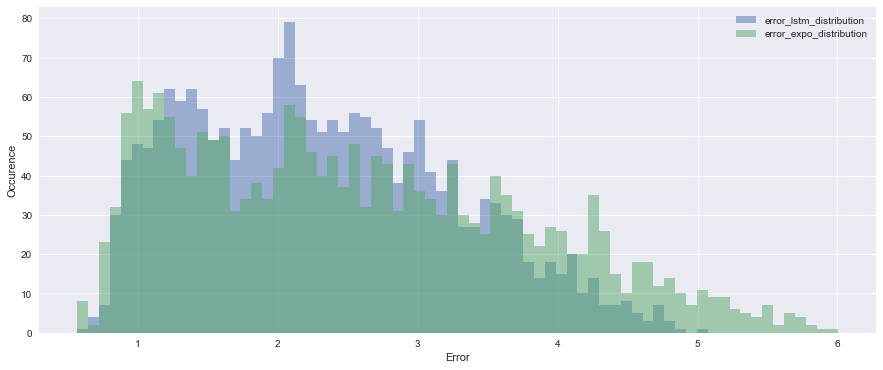

In [696]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

In [700]:
df_testRest.describe()

,error_lstm_distribution,error_expo_distribution
count,2000.000000,2000.000000
mean,2.315631,2.556883
std,0.929021,1.214184
min,0.621693,0.567743
25%,1.529385,1.510470
50%,2.210949,2.397830
75%,2.987527,3.446864
max,5.020494,6.005751


In [33]:
#exactly the same, same params, just take squared errors

def showOtherGraph_test_squared():
    startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps,size=())
    nbLabels = WaitingTimeAndTrade_test.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
#     print(np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))
#     print(np.average(np.square(returnPred_test(res_bench2_test.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))    
#     plt.title("Testing Model")

#     # Training Instance
#     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

#     # Target to Predict
#     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:], "ko", markersize=10, label="target")

#     # Models Prediction
#     plt.plot(y_pred[0,:,0][:-1], "r.", markersize=10, label="prediction LSTM")

#     plt.plot(returnPred_test(res_bench2_test.x), "b.", markersize=10, label="prediction Expo")
#     plt.xlabel("Time")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    
    return np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
            np.average(np.square(returnPred_test(res_bench2_test.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [703]:


error_lstm_dist = np.empty(shape = (0,0))
error_expo_dist = np.empty(shape = (0,0))
for i in range(0,2000):
    error_lstm, error_expo = showOtherGraph_test_squared()
    error_lstm_dist= np.append(error_lstm_dist,error_lstm)
    error_expo_dist = np.append(error_expo_dist,error_expo)
    

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
17.4066490187
23.9453766506
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.95260105244
11.5149153874
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.04615223229
11.6218131962
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
14.0981099495
19.7947479137
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.23141096789
5.33608935233
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.5244356616
15.8892776297
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
12.4740785837
18.10557307
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
26.1763590319
37.2210013654
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
16.5803477683
21.8884242633
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
14.5591791092
21.4324295059
INFO:tensorflow:Restoring parameters from ./rnn_time_series_mo

5.16040182972
3.69626317149
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.7598725575
15.7050189169
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.78930073145
10.5115789094
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.42129247346
11.6906810181
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.4065359807
1.969703502
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.65714337631
1.05859603385
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
13.0497929909
18.1063957469
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.1337702867
21.8275134705
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
23.0425945366
32.9229033746
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.65562189334
5.99629330863
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.60781728801
2.71321604025
INFO:tensorflow:Restoring parameter

1.7532678006
1.40328343427
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.0042914286
14.8883051204
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
20.0182153122
29.4511791873
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.44083894139
2.04812376241
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.9296798705
15.7022185234
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.70171139164
4.79214796159
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.83391996731
6.89800063319
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.3412124701
9.99649389565
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.72203297217
5.49307360009
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.12614401046
6.57558256427
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.98799465739
7.50000411846
INFO:tensorflow:Restoring paramete

20.2725395947
29.9047836388
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.00594102691
1.10805840236
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.5575560601
22.1118587601
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.0849744584
8.81805016785
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.04675923246
2.08355132131
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
14.5703640886
19.1938406023
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.10930757141
2.55520318543
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.29994245762
6.42925077477
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.7832357033
17.2838177817
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
18.0665279512
27.0824954286
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.2588088687
11.9564664147
INFO:tensorflow:Restoring paramet

6.48231575009
9.1715130115
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.29503601762
5.09922561929
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.6487225372
2.31432431659
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.6951635396
14.9671667425
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.928343552526
0.655320149362
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.93954873059
0.996963513792
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.52549480393
2.04891757263
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.93042095207
9.44655694753
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.06398039807
8.44947828594
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
12.4556909027
17.1170364229
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.34652406909
12.173546115
INFO:tensorflow:Restoring parame

10.728575061
13.5974259779
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.1096965759
16.6179534306
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.55301367416
1.63303464314
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.1450681686
0.983737995653
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.71820990235
1.41508070578
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
19.2873211205
28.50628758
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.36513442756
5.67611913724
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
16.4668821723
24.0858293272
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.18786372295
2.87855172191
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.04213092517
10.358417118
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
16.8848042578
24.0347262178
INFO:tensorflow:Restoring parameters

13.195618132
18.6671621797
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.7495002146
13.6806174553
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.88442489513
13.468486799
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.16841192536
2.57070261939
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.61730982401
3.95801395549
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
13.6030280911
17.250196697
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
12.7088008326
19.5239485427
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.13139987899
9.14863163574
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.92264588667
2.48783856853
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.23908636856
4.42862709966
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
13.3258489943
15.5574388706
INFO:tensorflow:Restoring parameter

10.9888177795
16.4597012903
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.28024573537
10.8023209752
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
13.4903262461
18.8123326817
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.04562654372
6.98740748038
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.2626791749
13.6098900283
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.252431073
20.8293534889
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
23.3687701951
32.9518402927
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
16.8090347859
21.4713812434
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.93062453337
8.01021165857
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.52986575713
12.5153955341
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.83269683201
5.20562989789
INFO:tensorflow:Restoring paramet

2.64336452832
2.75448976824
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.63227639949
2.87832225902
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
14.4349911885
21.4475448807
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.2045294107
6.71410306827
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.47047998726
5.44766528204
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.46398326464
1.93176013012
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.33045929824
1.29798407874
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.99284459127
4.03479868878
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
18.1950494183
24.8081347451
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.54080146071
1.9385808277
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.86332839693
8.58226966964
INFO:tensorflow:Restoring paramete

9.56390163943
12.6659710746
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.25103296076
4.00011569721
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
21.9600603666
31.9700557243
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.3381400732
13.7608717673
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.49950702226
6.05633396571
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.18209248726
1.73101840328
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.28023517922
1.5408112591
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.18361908383
11.2848198209
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
20.3077482514
28.9622202939
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.54402608802
1.96480150241
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.16761073013
1.74609838835
INFO:tensorflow:Restoring paramet

2.04890868121
1.21423088232
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
17.4104982802
23.6957753414
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.99454293124
8.66502191133
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.84533538214
12.5685249162
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.55605763076
8.0945399761
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.41664604661
6.64248616724
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.10399426046
9.59984566924
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.56257903526
10.380221604
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.79150368626
2.41725312255
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.56532561669
6.0521740058
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.41254009226
7.26518926645
INFO:tensorflow:Restoring parameter

10.8789935277
14.3325406128
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
20.9615706153
30.7284156212
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.38138563657
10.1940591875
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
16.7189980026
22.9120182618
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.5811668249
23.4335085939
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.99442383188
4.7444180195
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.3765506213
14.725934226
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.08783166013
0.868525124482
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.45810940173
1.14191301507
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.30270381803
7.18741205747
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.58047843199
9.42218568399
INFO:tensorflow:Restoring paramet

14.9623817679
15.3796523042
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.02146831471
1.86682473179
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.16039020611
0.912787117673
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.33206871088
9.87560767728
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.92570610702
1.89009830395
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
20.5232734573
30.2354086411
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.03394700147
8.37981950031
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.731346411
15.8430917458
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.4627980076
6.13957356682
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.9629647316
12.4894607017
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.49964527786
1.93365092406
INFO:tensorflow:Restoring paramet

8.98866641959
12.1690739252
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.90864177375
1.85733834493
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.43917067439
9.86854658105
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.4640275831
4.06703754018
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
12.7452756626
17.2018200632
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.42842368324
6.09215024976
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.46725061063
8.31354767477
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.4419346405
9.92987519112
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.1763519007
16.9014295992
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.85122656082
9.82053693133
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.99432432018
2.37679390094
INFO:tensorflow:Restoring paramete

4.12121993836
6.33718970941
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.13973680645
6.57936174126
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
12.1008958475
11.8452626419
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.4383338163
1.37380259724
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.75267064107
2.04982241131
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.96420480036
2.04239612334
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.77053438182
4.42839463085
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.84987020072
13.6587608899
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
14.1743848036
19.4945435428
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.9605770991
4.16710085784
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.58595267965
9.49983416537
INFO:tensorflow:Restoring paramete

8.76675758799
12.7588555068
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.43984669148
1.28557748881
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.37808862835
8.79048727751
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.87366697336
3.53726894435
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.8464287957
2.07065454881
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
16.8834510856
24.7439644648
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.71694874031
5.31954814189
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
0.929618706253
0.841797185507
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.44582771939
4.39330088119
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
13.6557716656
17.9609494958
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.61776114495
9.6553216364
INFO:tensorflow:Restoring parame

18.9995360967
28.3916447998
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.7112174827
14.8248318895
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.4170537996
14.7347375726
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.8262806403
9.78974191492
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.85341252543
7.00873704172
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.85075610974
2.5640108124
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.63661547075
3.52352914232
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.02852503197
3.48421171333
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.83614311966
3.63044737608
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
17.8651070158
25.0020060386
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
12.6225091344
15.7698409627
INFO:tensorflow:Restoring paramete

9.85044587167
13.181820447
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.46687828789
12.0624791557
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
13.4297144649
17.4077731042
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.6661457304
15.5834771175
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.06362822283
4.58166033312
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.85475423155
3.01487229223
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.7870513038
23.9002059153
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.29994492872
4.20973592598
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.95821561015
13.7393159024
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.83956576473
1.70353917126
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.84939461438
4.98913489878
INFO:tensorflow:Restoring paramet

8.00573611074
11.8659874111
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.02783970995
3.13013861036
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.6010416307
11.3429680939
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.27848514525
3.94355669818
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.1528543508
18.7147304441
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.11482339362
3.4061255792
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
11.276880686
15.0546554092
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.77419162058
6.20338839256
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.167070595
13.5596868815
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.72236528505
9.58306669884
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.01762507337
9.23309293367
INFO:tensorflow:Restoring parameter

15.4712338839
23.4675415091
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.22395361299
6.45665336314
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.75099923521
8.88212654673
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.76667717521
15.7026411118
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
10.1838660501
10.9791729077
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.2687068338
11.4961884528
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.37795234291
7.60081408001
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.27527259627
5.09233837818
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.71517612409
5.65090358837
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.83373081988
1.71334815913
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
16.4625457032
20.7057738663
INFO:tensorflow:Restoring paramet

15.2505963818
22.7439124563
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.87433936617
6.65705041446
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.93398631786
12.3045849699
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.7697320718
3.33517141794
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.89030373849
6.64465325966
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
13.5157074205
18.2286308954
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
14.9404427931
18.5832677031
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.33683662814
7.71271455386
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.68200434454
5.55922588845
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.54397586643
10.9811996688
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
7.51693470584
9.13288574065
INFO:tensorflow:Restoring paramet

6.6275611623
7.00091230086
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
2.17667515388
1.30631268571
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.58995894173
7.61051817392
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.5515608911
13.6857229545
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
6.8415386439
8.424572457
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
14.572836532
21.8736057681
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.28270926048
3.26733424359
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.82616078115
1.66732292184
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
4.33938421813
4.39852446541
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
14.6482734531
21.8307212399
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
8.02951542467
9.70736683056
INFO:tensorflow:Restoring parameters f

0.677832312532
0.746067845601
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.36928515799
1.42408933818
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
12.999321868
13.0774445856
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
15.3956769585
21.7346509851
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.47087274056
5.30337249394
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
13.8015270083
18.3189542486
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
1.5495425455
1.56702133948
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
3.05218405309
3.16687278155
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
5.71541356732
4.85412441024
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.32568758324
12.6902683182
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
9.01655011321
12.1687452845
INFO:tensorflow:Restoring parame

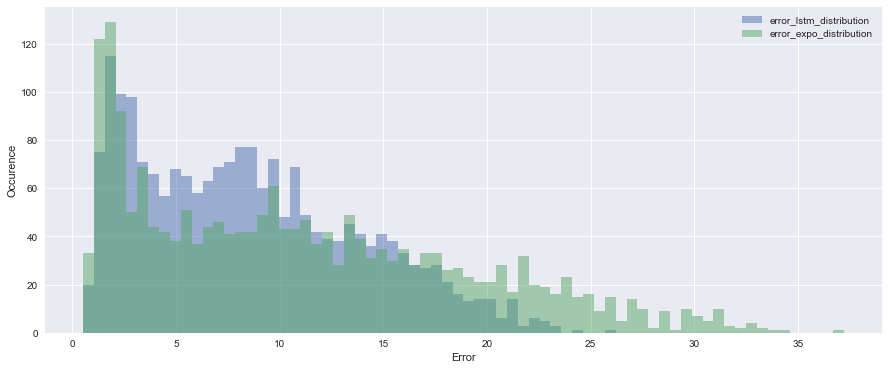

,error_lstm_distribution,error_expo_distribution
count,2000.000000,2000.000000
mean,8.515320,10.959851
std,5.331381,7.929121
min,0.644689,0.522280
25%,3.793525,3.742795
50%,7.891353,9.714161
75%,12.119717,16.352383
max,26.176359,37.221001


In [704]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

df_testRest.describe()

In [50]:
#New session try:

def residualExpoMovingAverageSQ_testingSet(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0]):
            counter = counter + 1
            if not first:
                errs.append(np.abs(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])


def returnPred_test(aParam,startTime) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime:startTime+num_time_steps][:-1]):

                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

                pred.append(ExpectedTime)
            
    return pred


In [51]:

def test_squared(n_iteration):
   
    error_lstm_dist = np.empty(shape = (0,0))
    error_expo_dist = np.empty(shape = (0,0))
    
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model") 
        for i in range(0,n_iteration):
            startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps,size=())
            nbLabels = WaitingTimeAndTrade_test.shape[1]
            X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
            y_pred = sess.run(outputs, feed_dict={X: X_new})
            error_lstm, error_expo = np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
                np.average(np.square(returnPred_test(res_bench2_test.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))
            error_lstm_dist= np.append(error_lstm_dist,error_lstm)
            error_expo_dist = np.append(error_expo_dist,error_expo)

    return pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])

In [52]:
# with gzip.open('data\\2017.10.16\\feeddata_10.json.gz', "rb") as f: #same set as tf model
#     data = json.loads(f.read().decode("ascii"))
# WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)
# res_bench2_test = optimize.minimize(residualExpoMovingAverageSQ_testingSet,[1], method='SLSQP', options={'maxiter':30000})

#Apply Chi-square distance on a new test :
with gzip.open('data\\2017.10.12\\feeddata_10.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))
    
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)


local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' 

In [55]:
df_testRest = test_squared(10000)

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


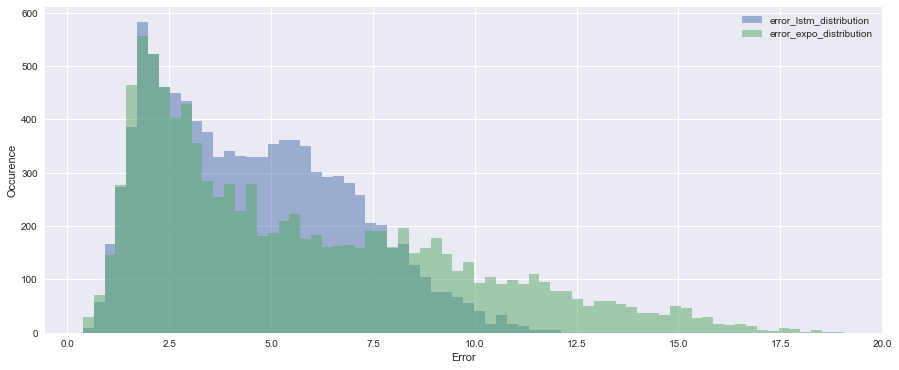

,error_lstm_distribution,error_expo_distribution
count,10000.000000,10000.000000
mean,4.550514,5.711773
std,2.327972,3.815958
min,0.466890,0.377687
25%,2.541698,2.495948
50%,4.297236,4.607741
75%,6.246064,8.290172
max,11.942598,19.058731


In [56]:
plt.style.use('seaborn')

df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

df_testRest.describe()

In [60]:
from scipy.stats import ks_2samp
ks_2samp(df_testRest['error_lstm_distribution'], df_testRest['error_expo_distribution'])

Ks_2sampResult(statistic=0.18340000000000001, pvalue=5.2600127905345668e-147)

In [58]:
#just to be really sure :

In [74]:
Stat = np.empty(shape = (0,0))
AverageExpo = np.empty(shape = (0,0))
AverageLSTM = np.empty(shape = (0,0))
STDExpo = np.empty(shape = (0,0))
STDLSTM = np.empty(shape = (0,0))
PValue = np.empty(shape = (0,0))

for i in range(1,30):
    for j in range(10,14):
        if i<10:
            myDay = "0"+str(i)
        else:
            myDay = str(i)
        myFile = Path('data\\2017.10.'+myDay+'\\feeddata_'+str(j)+'.json.gz')
        if myFile.exists():
            with gzip.open(myFile, "rb") as f:
                data = json.loads(f.read().decode("ascii"))

            WaitingTimeAndTrade_test = extractInterestingData(50000,whichStrikeAtMoney(data),data)
            df_testRest = test_squared(5000)
            Kolmo = ks_2samp(df_testRest['error_lstm_distribution'], df_testRest['error_expo_distribution'])
            Stat = np.append(Stat,Kolmo.statistic)
            PValue = np.append(PValue,Kolmo.pvalue)
            
            AverageExpo = np.append(AverageExpo,df_testRest['error_expo_distribution'].mean())
            AverageLSTM = np.append(AverageLSTM,df_testRest['error_lstm_distribution'].mean())
            STDExpo = np.append(STDExpo,df_testRest['error_expo_distribution'].std())
            STDLSTM = np.append(STDLSTM,df_testRest['error_lstm_distribution'].std())
            
KolmoDF = pd.DataFrame(data = np.column_stack([AverageLSTM, AverageExpo,STDLSTM,STDExpo, Stat,PValue]), columns=['Average Accuracy LSTM','Average Accuracy Expo','Std Accuracy LSTM','Std Accuracy Expo','Statistic', "Pvalue"])        


local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'ti

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime'

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local 

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local vari

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local vari

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'ti

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local 

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local 

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local vari

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' ref

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported 

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local vari

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local vari

In [76]:
KolmoDF.describe()

,Average Accuracy LSTM,Average Accuracy Expo,Std Accuracy LSTM,Std Accuracy Expo,Statistic,Pvalue
count,56.000000,56.000000,56.000000,56.000000,56.000000,5.600000e+01
mean,8.256999,10.745084,4.893033,7.404663,0.188311,4.210843e-26
std,2.079929,2.941014,1.186594,1.669067,0.062003,2.462862e-25
min,4.100060,4.515684,2.312408,3.775634,0.105000,0.000000e+00
25%,6.829121,8.370279,3.969970,6.170660,0.151800,1.270018e-98
50%,8.155340,10.628077,5.039954,7.428907,0.169100,1.108263e-62
75%,9.627775,12.479446,5.868279,8.852144,0.213500,4.309697e-50
max,13.330282,18.360921,6.921024,10.433717,0.420000,1.751389e-24


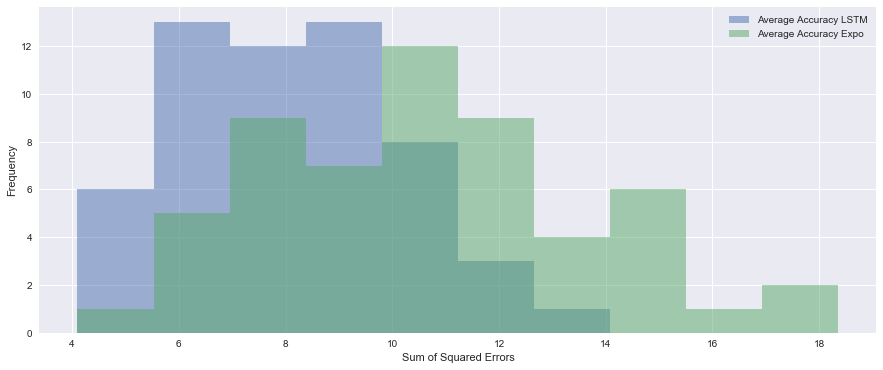

In [88]:
KolmoDF.drop("Std Accuracy LSTM",axis=1).drop("Std Accuracy Expo",axis=1).drop("Statistic",axis=1).drop("Pvalue",axis=1).plot.hist(alpha = 0.5, bins=10,figsize=(15,6))
plt.xlabel("Squared Errors")
plt.show()

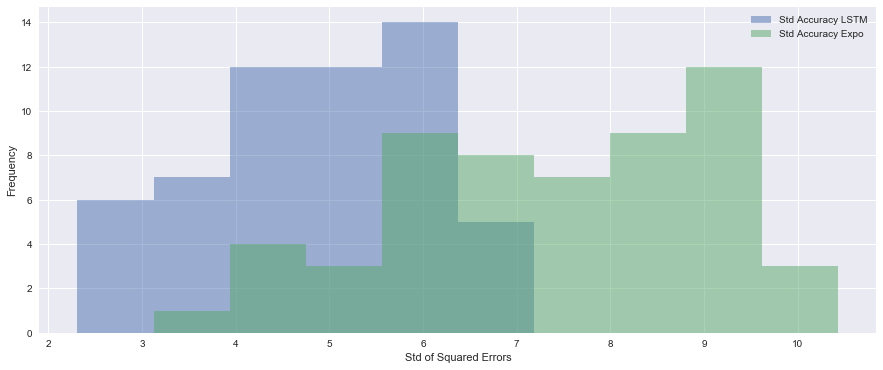

In [89]:
KolmoDF.drop("Average Accuracy LSTM",axis=1).drop("Average Accuracy Expo",axis=1).drop("Statistic",axis=1).drop("Pvalue",axis=1).plot.hist(alpha = 0.5, bins=10,figsize=(15,6))
plt.xlabel("Std of Squared Errors")
plt.show()

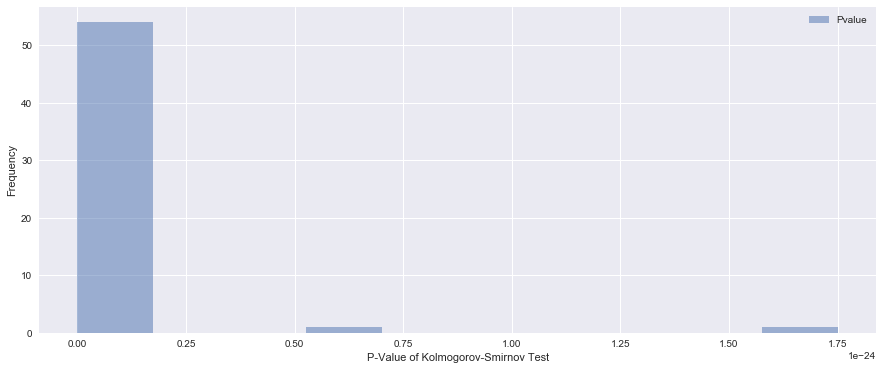

In [99]:
KolmoDF.drop("Std Accuracy LSTM",axis=1).drop("Std Accuracy Expo",axis=1).drop("Average Accuracy LSTM",axis=1).drop("Average Accuracy Expo",axis=1).drop("Statistic",axis=1).plot.hist(alpha = 0.5, bins=10,figsize=(15,6))
plt.xlabel("P-Value of Kolmogorov-Smirnov Test")
plt.show()